In [ ]:
# %%
%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import sys
sys.path.append("..")  # Add parent directory to Python path

from datagen import get_dataloader, create_file_pairs
from plotting import plot_log_residual_contour, plot_histogram
from models import Autoencoder1D, ConvAutoencoder1D

from tqdm import tqdm

os.environ["OPENBLAS_NUM_THREADS"] = "1"
plt.rcParams["figure.dpi"] = 110


In [2]:
# %%
def compute_log_residuals(x_true, x_recon):
    """
    x_true, x_recon: 1D arrays (NumPy)
    Returns: log_x_true, signed log_residual, residual (all NumPy)
    """
    residual = x_true - x_recon
    log_x_true = np.log10(np.abs(x_true) + 1e-12)
    log_residual = np.sign(residual) * np.log10(np.abs(residual) + 1e-12)
    return log_x_true, log_residual, residual


def compute_rule_based_residual_magnitude(log_x_true, m=23, epsilon=0.3):
    """
    Rule-based upper/lower lines in log space.
    """
    delta_x = np.log10(2)
    C = -m * delta_x + epsilon
    x_step = np.floor(log_x_true / delta_x) * delta_x
    y_upper = x_step + C
    y_lower = -x_step - C
    y_mid = (y_upper + y_lower) / 2
    return y_mid, y_upper, y_lower, x_step


def plot_rule_based_bounds(log_x_true, log_residual, y_upper, y_lower, x_step, m, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.scatter(log_x_true, log_residual, s=5, alpha=0.2, label="Residuals")
    sort_idx = np.argsort(x_step)
    plt.plot(x_step[sort_idx], y_upper[sort_idx], 'r--', label=f"$y = x - {m}\\log_{{10}}2 + \\epsilon$")
    plt.plot(x_step[sort_idx], y_lower[sort_idx], 'b--', label=f"$y = -x + {m}\\log_{{10}}2 - \\epsilon$")
    plt.xlabel("log10(|x_true|)")
    plt.ylabel("Signed log10 residual")
    plt.title("Rule-Based Residual Bounds")
    plt.legend()
    plt.grid(True)
    if save_path is not None:
        out = Path(save_path) / "rule_based_bounds.png"
        plt.savefig(out, bbox_inches="tight")
        plt.close()
        print(f"Rule-based bounds plot saved to {out}")
    else:
        plt.show()


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoencoder1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):
        B, C, L = x.shape
        # compute next multiple of 4
        factor = 2 ** 2  # two stride-2 layers
        pad_len = (factor - (L % factor)) % factor
        if pad_len > 0:
            # pad on the right only
            x = F.pad(x, (0, pad_len))

        z = self.encoder(x)
        out = self.decoder(z)

        # crop back to original length
        out = out[..., :L]
        return out


In [4]:
# %%
device = "cuda" if torch.cuda.is_available() else "cpu"

branch = "AnalysisElectronsAuxDyn"
varnames = ["pt"]
batch_size = 1000
dataloader = get_dataloader(branch=branch, varnames=varnames, batch_size=batch_size, shuffle=False)
# Global mean/std/min/max across dataset
total_sum, total_sq_sum, total_count = 0.0, 0.0, 0
global_min, global_max = float("inf"), float("-inf")

for x_compressed, residual in dataloader:
    x_clean = x_compressed.squeeze(1).to(device)

    # Update sums for mean/std
    total_sum    += x_clean.sum().item()
    total_sq_sum += (x_clean ** 2).sum().item()
    total_count  += x_clean.numel()

    # Update min/max
    batch_min = x_clean.min().item()
    batch_max = x_clean.max().item()
    global_min = min(global_min, batch_min)
    global_max = max(global_max, batch_max)

mean_src = total_sum / total_count
var_src  = total_sq_sum / total_count - mean_src**2
std_src  = np.sqrt(max(var_src, 1e-20))

print(f"[Norm] mean={mean_src:.6g}, std={std_src:.6g}, min={global_min:.6g}, max={global_max:.6g}")



[Norm] mean=29603.1, std=34961.9, min=712, max=716800


In [5]:
dataloader = get_dataloader(branch=branch, varnames=varnames, hist=False, full_sample_mode=True, range=(global_min, global_max), batch_size=1, shuffle=False)

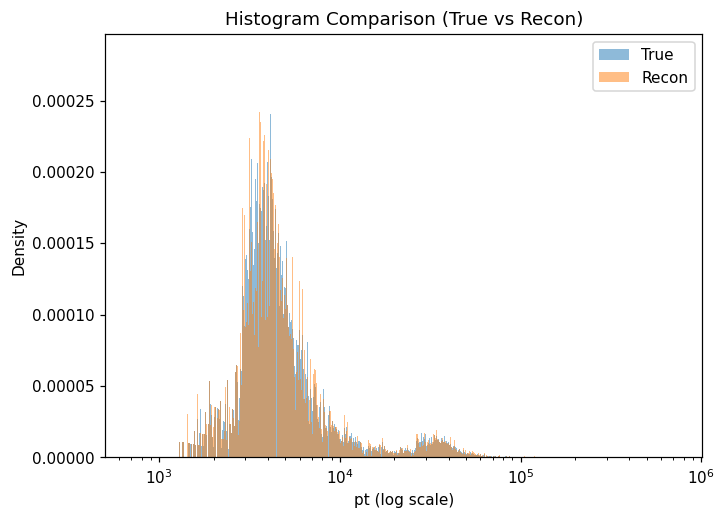

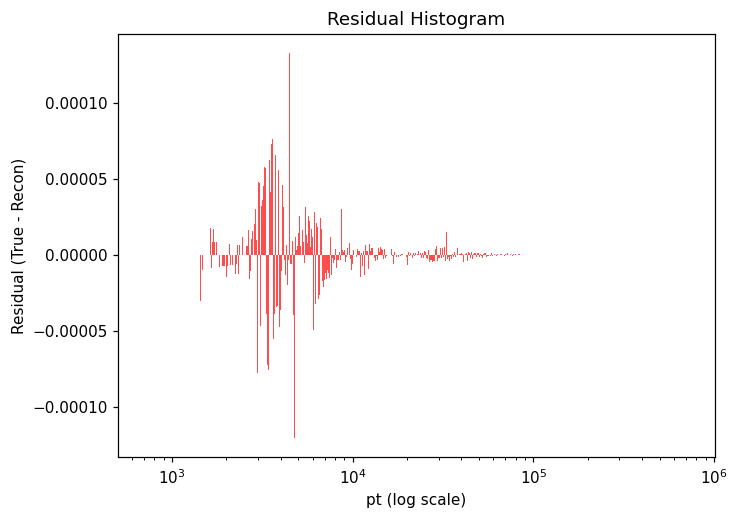

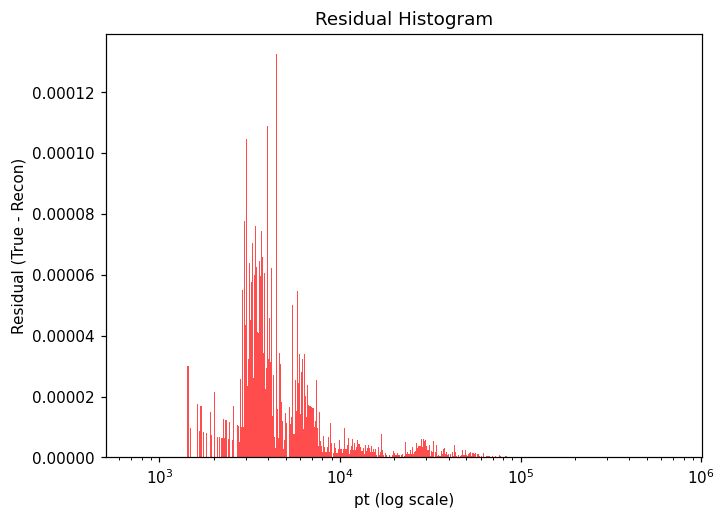

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# grab one full sample (x_recon, residuals) from dataset
x_recon, residual = dataloader.dataset[0]  
x_recon = x_recon.numpy()
residual = residual.numpy()
x_true = x_recon + residual   # reconstruct true values

# choose which variable to plot (if multiple varnames)
var_idx = 0  

# build log-spaced bins using dataset.range
low, high = dataloader.dataset.range
bins = dataloader.dataset.bins
bin_edges = np.logspace(np.log10(low), np.log10(high), bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# make histograms
h_true, _ = np.histogram(x_true[:, var_idx], bins=bin_edges, density=True)
h_recon, _ = np.histogram(x_recon[:, var_idx], bins=bin_edges, density=True)
h_residual = h_true - h_recon

# --- plot ---
plt.figure(figsize=(7,5))
plt.bar(bin_centers, h_true, width=np.diff(bin_edges), alpha=0.5, label="True", align="center")
plt.bar(bin_centers, h_recon, width=np.diff(bin_edges), alpha=0.5, label="Recon", align="center")
plt.xscale("log")
plt.xlabel(dataloader.dataset.varnames[var_idx] + " (log scale)")
plt.ylabel("Density")
plt.title("Histogram Comparison (True vs Recon)")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.bar(bin_centers, h_residual, width=np.diff(bin_edges), alpha=0.7, color="red", align="center")
plt.xscale("log")
plt.xlabel(dataloader.dataset.varnames[var_idx] + " (log scale)")
plt.ylabel("Residual (True - Recon)")
plt.title("Residual Histogram")
plt.show()

plt.figure(figsize=(7,5))
plt.bar(bin_centers, np.abs(h_residual), width=np.diff(bin_edges), alpha=0.7, color="red", align="center")
plt.xscale("log")
plt.xlabel(dataloader.dataset.varnames[var_idx] + " (log scale)")
plt.ylabel("Residual (True - Recon)")
plt.title("Residual Histogram")
plt.show()


In [7]:
# next(iter(dataloader))[0].shape
dataloader.dataset[0][0].shape

torch.Size([10019, 1])

ValueError: x and y must have same first dimension, but have shapes (10019,) and (6939, 1)

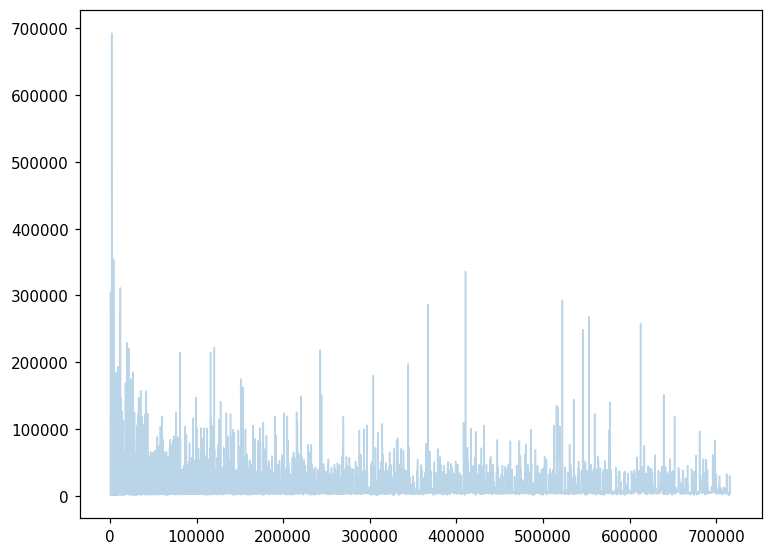

In [8]:
# Access dataset
dataset = dataloader.dataset

low, high = dataset.range
bin_edges = np.logspace(np.log10(low), np.log10(high), len(dataset[0][0]) + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(8, 6))

# Loop over all samples
for i in range(len(dataset)):
    h_rec, _ = dataset[i]  # (reconstructed histogram and residual)
    plt.step(bin_centers, h_rec, where="mid", alpha=0.3, lw=1)

plt.xscale("log")
plt.title("Overlay of reconstructed histograms")
plt.xlabel("Variable (log scale)")
plt.ylabel("Counts (normalized)")
plt.show()


In [9]:
# %%
model = ConvAutoencoder1D().to(device)
# model.load_state_dict(torch.load("denoiser.pth"))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 500
batch_size = 1
noise_std = 0.01

use_kl = False  # <-- switch here: True = KLDivLoss, False = MSELoss

if use_kl:
    criterion = torch.nn.KLDivLoss(reduction="batchmean")  # expects log-prob input vs prob target
else:
    criterion = torch.nn.MSELoss()

loss_history = []

for epoch in range(epochs):
    running_loss = 0.0
    total_samples = 0
    
    for h_rec, h_res in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        h_rec = h_rec.squeeze().to(device)   # (L,)
        h_res = h_res.squeeze().to(device)   # (L,)
        # print(h_rec.shape, h_res.shape)  # (L,) (L,)
        # Ground truth histogram
        h_true = (h_rec + h_res)     # (L,)

        # if use_kl:
        #     # Normalize to probability distribution
        # h_true = h_true / (h_true.sum() + 1e-8)
        # h_input = h_rec / (h_rec.sum() + 1e-8)
        # else:
        #     # Standardize with mean/std (global dataset stats)
        h_true = (h_true - mean_src) / (std_src + 1e-8)
        h_input = (h_rec - mean_src) / (std_src + 1e-8)

        # Build batch
        h_true_batch = h_true.unsqueeze(0).unsqueeze(0)#.expand(batch_size, -1, -1)  # (B,1,L)
        h_input_batch = h_rec.unsqueeze(0).unsqueeze(0)#.expand(batch_size, -1, -1)  # (B,1,L)
        # Add Gaussian noise
        h_input_batch = h_input_batch + torch.randn_like(h_input_batch) * noise_std

        # Forward
        pred = model(h_input_batch)

        if use_kl:
            # KLDivLoss expects log-probs as input, probs as target
            pred_log = torch.log_softmax(pred, dim=-1)     # log-probs
            target_prob = torch.softmax(h_true_batch, dim=-1)  # ensure valid probs
            loss = criterion(pred_log, target_prob)
        else:
            loss = criterion(pred, h_true_batch)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_size
        total_samples += batch_size

    avg_loss = running_loss / total_samples
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f}")


Epoch 1/500: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


Epoch 1/500 | Loss: 12291185.500000


Epoch 2/500: 100%|██████████| 4/4 [00:00<00:00, 131.52it/s]


Epoch 2/500 | Loss: 4188539.937500


Epoch 3/500: 100%|██████████| 4/4 [00:00<00:00, 112.00it/s]


Epoch 3/500 | Loss: 2632116.000000


Epoch 4/500: 100%|██████████| 4/4 [00:00<00:00, 85.38it/s]


Epoch 4/500 | Loss: 1694584.125000


Epoch 5/500: 100%|██████████| 4/4 [00:00<00:00, 110.71it/s]


Epoch 5/500 | Loss: 1181695.812500


Epoch 6/500: 100%|██████████| 4/4 [00:00<00:00, 99.39it/s]


Epoch 6/500 | Loss: 839139.687500


Epoch 7/500: 100%|██████████| 4/4 [00:00<00:00, 107.92it/s]


Epoch 7/500 | Loss: 611476.812500


Epoch 8/500: 100%|██████████| 4/4 [00:00<00:00, 98.66it/s]


Epoch 8/500 | Loss: 496351.679688


Epoch 9/500: 100%|██████████| 4/4 [00:00<00:00, 138.82it/s]


Epoch 9/500 | Loss: 416433.132812


Epoch 10/500: 100%|██████████| 4/4 [00:00<00:00, 125.38it/s]


Epoch 10/500 | Loss: 349248.550781


Epoch 11/500: 100%|██████████| 4/4 [00:00<00:00, 109.35it/s]


Epoch 11/500 | Loss: 306892.292969


Epoch 12/500: 100%|██████████| 4/4 [00:00<00:00, 86.23it/s]


Epoch 12/500 | Loss: 274130.023438


Epoch 13/500: 100%|██████████| 4/4 [00:00<00:00, 107.13it/s]


Epoch 13/500 | Loss: 245713.648438


Epoch 14/500: 100%|██████████| 4/4 [00:00<00:00, 82.35it/s]


Epoch 14/500 | Loss: 223819.542969


Epoch 15/500: 100%|██████████| 4/4 [00:00<00:00, 108.44it/s]


Epoch 15/500 | Loss: 204641.560547


Epoch 16/500: 100%|██████████| 4/4 [00:00<00:00, 100.12it/s]


Epoch 16/500 | Loss: 188045.964844


Epoch 17/500: 100%|██████████| 4/4 [00:00<00:00, 120.82it/s]


Epoch 17/500 | Loss: 174446.050781


Epoch 18/500: 100%|██████████| 4/4 [00:00<00:00, 109.82it/s]


Epoch 18/500 | Loss: 162546.119141


Epoch 19/500: 100%|██████████| 4/4 [00:00<00:00, 123.05it/s]


Epoch 19/500 | Loss: 152413.259766


Epoch 20/500: 100%|██████████| 4/4 [00:00<00:00, 129.22it/s]


Epoch 20/500 | Loss: 143255.589844


Epoch 21/500: 100%|██████████| 4/4 [00:00<00:00, 121.40it/s]


Epoch 21/500 | Loss: 134956.333984


Epoch 22/500: 100%|██████████| 4/4 [00:00<00:00, 98.27it/s]


Epoch 22/500 | Loss: 127537.767578


Epoch 23/500: 100%|██████████| 4/4 [00:00<00:00, 111.42it/s]


Epoch 23/500 | Loss: 120691.072266


Epoch 24/500: 100%|██████████| 4/4 [00:00<00:00, 108.07it/s]


Epoch 24/500 | Loss: 114364.396484


Epoch 25/500: 100%|██████████| 4/4 [00:00<00:00, 139.35it/s]


Epoch 25/500 | Loss: 108497.101562


Epoch 26/500: 100%|██████████| 4/4 [00:00<00:00, 87.47it/s]


Epoch 26/500 | Loss: 103033.912109


Epoch 27/500: 100%|██████████| 4/4 [00:00<00:00, 101.82it/s]


Epoch 27/500 | Loss: 97929.297852


Epoch 28/500: 100%|██████████| 4/4 [00:00<00:00, 86.63it/s]


Epoch 28/500 | Loss: 93130.506836


Epoch 29/500: 100%|██████████| 4/4 [00:00<00:00, 134.72it/s]


Epoch 29/500 | Loss: 88612.462891


Epoch 30/500: 100%|██████████| 4/4 [00:00<00:00, 97.47it/s]


Epoch 30/500 | Loss: 84347.743164


Epoch 31/500: 100%|██████████| 4/4 [00:00<00:00, 95.38it/s]


Epoch 31/500 | Loss: 80298.856445


Epoch 32/500: 100%|██████████| 4/4 [00:00<00:00, 135.38it/s]


Epoch 32/500 | Loss: 76436.321289


Epoch 33/500: 100%|██████████| 4/4 [00:00<00:00, 95.67it/s]


Epoch 33/500 | Loss: 72708.791016


Epoch 34/500: 100%|██████████| 4/4 [00:00<00:00, 125.18it/s]


Epoch 34/500 | Loss: 69148.061523


Epoch 35/500: 100%|██████████| 4/4 [00:00<00:00, 93.61it/s]


Epoch 35/500 | Loss: 65785.026367


Epoch 36/500: 100%|██████████| 4/4 [00:00<00:00, 80.33it/s]


Epoch 36/500 | Loss: 62568.113281


Epoch 37/500: 100%|██████████| 4/4 [00:00<00:00, 63.28it/s]


Epoch 37/500 | Loss: 59427.077148


Epoch 38/500: 100%|██████████| 4/4 [00:00<00:00, 60.88it/s]


Epoch 38/500 | Loss: 56345.243652


Epoch 39/500: 100%|██████████| 4/4 [00:00<00:00, 75.27it/s]


Epoch 39/500 | Loss: 53394.085938


Epoch 40/500: 100%|██████████| 4/4 [00:00<00:00, 75.56it/s]


Epoch 40/500 | Loss: 50622.771973


Epoch 41/500: 100%|██████████| 4/4 [00:00<00:00, 74.65it/s]


Epoch 41/500 | Loss: 47992.605469


Epoch 42/500: 100%|██████████| 4/4 [00:00<00:00, 46.52it/s]


Epoch 42/500 | Loss: 45542.810547


Epoch 43/500: 100%|██████████| 4/4 [00:00<00:00, 103.57it/s]


Epoch 43/500 | Loss: 43296.998535


Epoch 44/500: 100%|██████████| 4/4 [00:00<00:00, 115.18it/s]


Epoch 44/500 | Loss: 41238.483398


Epoch 45/500: 100%|██████████| 4/4 [00:00<00:00, 112.62it/s]


Epoch 45/500 | Loss: 39324.859863


Epoch 46/500: 100%|██████████| 4/4 [00:00<00:00, 95.67it/s]


Epoch 46/500 | Loss: 37516.015137


Epoch 47/500: 100%|██████████| 4/4 [00:00<00:00, 52.68it/s]


Epoch 47/500 | Loss: 35789.584473


Epoch 48/500: 100%|██████████| 4/4 [00:00<00:00, 58.13it/s]


Epoch 48/500 | Loss: 34102.299805


Epoch 49/500: 100%|██████████| 4/4 [00:00<00:00, 64.62it/s]


Epoch 49/500 | Loss: 32445.877930


Epoch 50/500: 100%|██████████| 4/4 [00:00<00:00, 81.51it/s]


Epoch 50/500 | Loss: 30754.145020


Epoch 51/500: 100%|██████████| 4/4 [00:00<00:00, 85.00it/s]


Epoch 51/500 | Loss: 28917.057129


Epoch 52/500: 100%|██████████| 4/4 [00:00<00:00, 77.20it/s]


Epoch 52/500 | Loss: 26771.398438


Epoch 53/500: 100%|██████████| 4/4 [00:00<00:00, 45.45it/s]


Epoch 53/500 | Loss: 24024.579590


Epoch 54/500: 100%|██████████| 4/4 [00:00<00:00, 100.33it/s]


Epoch 54/500 | Loss: 20203.910156


Epoch 55/500: 100%|██████████| 4/4 [00:00<00:00, 102.08it/s]


Epoch 55/500 | Loss: 15258.395264


Epoch 56/500: 100%|██████████| 4/4 [00:00<00:00, 122.21it/s]


Epoch 56/500 | Loss: 10396.848145


Epoch 57/500: 100%|██████████| 4/4 [00:00<00:00, 100.60it/s]


Epoch 57/500 | Loss: 6704.342773


Epoch 58/500: 100%|██████████| 4/4 [00:00<00:00, 46.44it/s]


Epoch 58/500 | Loss: 4216.190125


Epoch 59/500: 100%|██████████| 4/4 [00:00<00:00, 51.42it/s]


Epoch 59/500 | Loss: 2654.480652


Epoch 60/500: 100%|██████████| 4/4 [00:00<00:00, 67.14it/s]


Epoch 60/500 | Loss: 1738.371124


Epoch 61/500: 100%|██████████| 4/4 [00:00<00:00, 65.86it/s]


Epoch 61/500 | Loss: 1208.654800


Epoch 62/500: 100%|██████████| 4/4 [00:00<00:00, 113.64it/s]


Epoch 62/500 | Loss: 901.987488


Epoch 63/500: 100%|██████████| 4/4 [00:00<00:00, 116.01it/s]


Epoch 63/500 | Loss: 713.487732


Epoch 64/500: 100%|██████████| 4/4 [00:00<00:00, 120.09it/s]


Epoch 64/500 | Loss: 585.682556


Epoch 65/500: 100%|██████████| 4/4 [00:00<00:00, 105.07it/s]


Epoch 65/500 | Loss: 489.396164


Epoch 66/500: 100%|██████████| 4/4 [00:00<00:00, 108.06it/s]


Epoch 66/500 | Loss: 412.773949


Epoch 67/500: 100%|██████████| 4/4 [00:00<00:00, 95.77it/s]


Epoch 67/500 | Loss: 352.620987


Epoch 68/500: 100%|██████████| 4/4 [00:00<00:00, 109.41it/s]


Epoch 68/500 | Loss: 308.457142


Epoch 69/500: 100%|██████████| 4/4 [00:00<00:00, 98.25it/s]


Epoch 69/500 | Loss: 275.021820


Epoch 70/500: 100%|██████████| 4/4 [00:00<00:00, 101.12it/s]


Epoch 70/500 | Loss: 248.933580


Epoch 71/500: 100%|██████████| 4/4 [00:00<00:00, 105.21it/s]


Epoch 71/500 | Loss: 227.648930


Epoch 72/500: 100%|██████████| 4/4 [00:00<00:00, 37.87it/s]


Epoch 72/500 | Loss: 209.961964


Epoch 73/500: 100%|██████████| 4/4 [00:00<00:00, 114.02it/s]


Epoch 73/500 | Loss: 195.246943


Epoch 74/500: 100%|██████████| 4/4 [00:00<00:00, 111.80it/s]


Epoch 74/500 | Loss: 183.013144


Epoch 75/500: 100%|██████████| 4/4 [00:00<00:00, 119.27it/s]


Epoch 75/500 | Loss: 172.499520


Epoch 76/500: 100%|██████████| 4/4 [00:00<00:00, 131.43it/s]


Epoch 76/500 | Loss: 163.346884


Epoch 77/500: 100%|██████████| 4/4 [00:00<00:00, 95.16it/s]


Epoch 77/500 | Loss: 155.007946


Epoch 78/500: 100%|██████████| 4/4 [00:00<00:00, 108.95it/s]


Epoch 78/500 | Loss: 146.995945


Epoch 79/500: 100%|██████████| 4/4 [00:00<00:00, 137.98it/s]


Epoch 79/500 | Loss: 139.647242


Epoch 80/500: 100%|██████████| 4/4 [00:00<00:00, 119.55it/s]


Epoch 80/500 | Loss: 132.885735


Epoch 81/500: 100%|██████████| 4/4 [00:00<00:00, 114.87it/s]


Epoch 81/500 | Loss: 126.562806


Epoch 82/500: 100%|██████████| 4/4 [00:00<00:00, 120.08it/s]


Epoch 82/500 | Loss: 120.689757


Epoch 83/500: 100%|██████████| 4/4 [00:00<00:00, 129.92it/s]


Epoch 83/500 | Loss: 115.257527


Epoch 84/500: 100%|██████████| 4/4 [00:00<00:00, 113.00it/s]


Epoch 84/500 | Loss: 110.204140


Epoch 85/500: 100%|██████████| 4/4 [00:00<00:00, 117.12it/s]


Epoch 85/500 | Loss: 105.489875


Epoch 86/500: 100%|██████████| 4/4 [00:00<00:00, 150.10it/s]


Epoch 86/500 | Loss: 101.004138


Epoch 87/500: 100%|██████████| 4/4 [00:00<00:00, 132.83it/s]


Epoch 87/500 | Loss: 96.796422


Epoch 88/500: 100%|██████████| 4/4 [00:00<00:00, 112.80it/s]


Epoch 88/500 | Loss: 92.834468


Epoch 89/500: 100%|██████████| 4/4 [00:00<00:00, 98.26it/s]


Epoch 89/500 | Loss: 89.116462


Epoch 90/500: 100%|██████████| 4/4 [00:00<00:00, 129.49it/s]


Epoch 90/500 | Loss: 85.630418


Epoch 91/500: 100%|██████████| 4/4 [00:00<00:00, 124.81it/s]


Epoch 91/500 | Loss: 82.371976


Epoch 92/500: 100%|██████████| 4/4 [00:00<00:00, 114.91it/s]


Epoch 92/500 | Loss: 79.323809


Epoch 93/500: 100%|██████████| 4/4 [00:00<00:00, 150.25it/s]


Epoch 93/500 | Loss: 76.464177


Epoch 94/500: 100%|██████████| 4/4 [00:00<00:00, 125.72it/s]


Epoch 94/500 | Loss: 73.692776


Epoch 95/500: 100%|██████████| 4/4 [00:00<00:00, 123.71it/s]


Epoch 95/500 | Loss: 70.965362


Epoch 96/500: 100%|██████████| 4/4 [00:00<00:00, 106.43it/s]


Epoch 96/500 | Loss: 68.316741


Epoch 97/500: 100%|██████████| 4/4 [00:00<00:00, 134.18it/s]


Epoch 97/500 | Loss: 65.746454


Epoch 98/500: 100%|██████████| 4/4 [00:00<00:00, 136.59it/s]


Epoch 98/500 | Loss: 63.254224


Epoch 99/500: 100%|██████████| 4/4 [00:00<00:00, 142.18it/s]


Epoch 99/500 | Loss: 60.862824


Epoch 100/500: 100%|██████████| 4/4 [00:00<00:00, 118.51it/s]


Epoch 100/500 | Loss: 58.573046


Epoch 101/500: 100%|██████████| 4/4 [00:00<00:00, 129.03it/s]


Epoch 101/500 | Loss: 56.392767


Epoch 102/500: 100%|██████████| 4/4 [00:00<00:00, 116.45it/s]


Epoch 102/500 | Loss: 54.307485


Epoch 103/500: 100%|██████████| 4/4 [00:00<00:00, 121.09it/s]


Epoch 103/500 | Loss: 52.317511


Epoch 104/500: 100%|██████████| 4/4 [00:00<00:00, 52.47it/s]


Epoch 104/500 | Loss: 50.421501


Epoch 105/500: 100%|██████████| 4/4 [00:00<00:00, 110.88it/s]


Epoch 105/500 | Loss: 48.613417


Epoch 106/500: 100%|██████████| 4/4 [00:00<00:00, 109.13it/s]


Epoch 106/500 | Loss: 46.894839


Epoch 107/500: 100%|██████████| 4/4 [00:00<00:00, 92.13it/s]


Epoch 107/500 | Loss: 45.257237


Epoch 108/500: 100%|██████████| 4/4 [00:00<00:00, 113.84it/s]


Epoch 108/500 | Loss: 43.693392


Epoch 109/500: 100%|██████████| 4/4 [00:00<00:00, 120.49it/s]


Epoch 109/500 | Loss: 42.206165


Epoch 110/500: 100%|██████████| 4/4 [00:00<00:00, 120.58it/s]


Epoch 110/500 | Loss: 40.786769


Epoch 111/500: 100%|██████████| 4/4 [00:00<00:00, 125.79it/s]


Epoch 111/500 | Loss: 39.428117


Epoch 112/500: 100%|██████████| 4/4 [00:00<00:00, 113.06it/s]


Epoch 112/500 | Loss: 38.134770


Epoch 113/500: 100%|██████████| 4/4 [00:00<00:00, 121.85it/s]


Epoch 113/500 | Loss: 36.891631


Epoch 114/500: 100%|██████████| 4/4 [00:00<00:00, 106.22it/s]


Epoch 114/500 | Loss: 35.702267


Epoch 115/500: 100%|██████████| 4/4 [00:00<00:00, 114.22it/s]


Epoch 115/500 | Loss: 34.556838


Epoch 116/500: 100%|██████████| 4/4 [00:00<00:00, 103.29it/s]


Epoch 116/500 | Loss: 33.456075


Epoch 117/500: 100%|██████████| 4/4 [00:00<00:00, 93.19it/s]


Epoch 117/500 | Loss: 32.405577


Epoch 118/500: 100%|██████████| 4/4 [00:00<00:00, 99.50it/s]


Epoch 118/500 | Loss: 31.398690


Epoch 119/500: 100%|██████████| 4/4 [00:00<00:00, 88.93it/s]


Epoch 119/500 | Loss: 30.437613


Epoch 120/500: 100%|██████████| 4/4 [00:00<00:00, 85.20it/s]


Epoch 120/500 | Loss: 29.516445


Epoch 121/500: 100%|██████████| 4/4 [00:00<00:00, 94.59it/s]


Epoch 121/500 | Loss: 28.635339


Epoch 122/500: 100%|██████████| 4/4 [00:00<00:00, 78.35it/s]


Epoch 122/500 | Loss: 27.791618


Epoch 123/500: 100%|██████████| 4/4 [00:00<00:00, 97.99it/s]


Epoch 123/500 | Loss: 26.979242


Epoch 124/500: 100%|██████████| 4/4 [00:00<00:00, 97.95it/s]


Epoch 124/500 | Loss: 26.200266


Epoch 125/500: 100%|██████████| 4/4 [00:00<00:00, 81.58it/s]


Epoch 125/500 | Loss: 25.453498


Epoch 126/500: 100%|██████████| 4/4 [00:00<00:00, 90.97it/s]


Epoch 126/500 | Loss: 24.735560


Epoch 127/500: 100%|██████████| 4/4 [00:00<00:00, 84.70it/s]


Epoch 127/500 | Loss: 24.052638


Epoch 128/500: 100%|██████████| 4/4 [00:00<00:00, 88.54it/s]


Epoch 128/500 | Loss: 23.396918


Epoch 129/500: 100%|██████████| 4/4 [00:00<00:00, 74.62it/s]


Epoch 129/500 | Loss: 22.765966


Epoch 130/500: 100%|██████████| 4/4 [00:00<00:00, 75.24it/s]


Epoch 130/500 | Loss: 22.156259


Epoch 131/500: 100%|██████████| 4/4 [00:00<00:00, 83.35it/s]


Epoch 131/500 | Loss: 21.569821


Epoch 132/500: 100%|██████████| 4/4 [00:00<00:00, 75.59it/s]


Epoch 132/500 | Loss: 21.002852


Epoch 133/500: 100%|██████████| 4/4 [00:00<00:00, 102.70it/s]


Epoch 133/500 | Loss: 20.452278


Epoch 134/500: 100%|██████████| 4/4 [00:00<00:00, 101.45it/s]


Epoch 134/500 | Loss: 19.920166


Epoch 135/500: 100%|██████████| 4/4 [00:00<00:00, 116.67it/s]


Epoch 135/500 | Loss: 19.397367


Epoch 136/500: 100%|██████████| 4/4 [00:00<00:00, 106.55it/s]


Epoch 136/500 | Loss: 18.848850


Epoch 137/500: 100%|██████████| 4/4 [00:00<00:00, 95.93it/s]


Epoch 137/500 | Loss: 18.277921


Epoch 138/500: 100%|██████████| 4/4 [00:00<00:00, 86.92it/s]


Epoch 138/500 | Loss: 17.699556


Epoch 139/500: 100%|██████████| 4/4 [00:00<00:00, 119.57it/s]


Epoch 139/500 | Loss: 17.124232


Epoch 140/500: 100%|██████████| 4/4 [00:00<00:00, 92.05it/s]


Epoch 140/500 | Loss: 16.550986


Epoch 141/500: 100%|██████████| 4/4 [00:00<00:00, 103.54it/s]


Epoch 141/500 | Loss: 15.992996


Epoch 142/500: 100%|██████████| 4/4 [00:00<00:00, 118.13it/s]


Epoch 142/500 | Loss: 15.453537


Epoch 143/500: 100%|██████████| 4/4 [00:00<00:00, 103.08it/s]


Epoch 143/500 | Loss: 14.934828


Epoch 144/500: 100%|██████████| 4/4 [00:00<00:00, 57.66it/s]


Epoch 144/500 | Loss: 14.435955


Epoch 145/500: 100%|██████████| 4/4 [00:00<00:00, 101.21it/s]


Epoch 145/500 | Loss: 13.959848


Epoch 146/500: 100%|██████████| 4/4 [00:00<00:00, 121.50it/s]


Epoch 146/500 | Loss: 13.504533


Epoch 147/500: 100%|██████████| 4/4 [00:00<00:00, 113.67it/s]


Epoch 147/500 | Loss: 13.069114


Epoch 148/500: 100%|██████████| 4/4 [00:00<00:00, 97.01it/s]


Epoch 148/500 | Loss: 12.653863


Epoch 149/500: 100%|██████████| 4/4 [00:00<00:00, 93.62it/s]


Epoch 149/500 | Loss: 12.256078


Epoch 150/500: 100%|██████████| 4/4 [00:00<00:00, 110.19it/s]


Epoch 150/500 | Loss: 11.875527


Epoch 151/500: 100%|██████████| 4/4 [00:00<00:00, 94.03it/s]


Epoch 151/500 | Loss: 11.509284


Epoch 152/500: 100%|██████████| 4/4 [00:00<00:00, 95.98it/s]


Epoch 152/500 | Loss: 11.159230


Epoch 153/500: 100%|██████████| 4/4 [00:00<00:00, 114.09it/s]


Epoch 153/500 | Loss: 10.824335


Epoch 154/500: 100%|██████████| 4/4 [00:00<00:00, 83.55it/s]


Epoch 154/500 | Loss: 10.503786


Epoch 155/500: 100%|██████████| 4/4 [00:00<00:00, 111.90it/s]


Epoch 155/500 | Loss: 10.197556


Epoch 156/500: 100%|██████████| 4/4 [00:00<00:00, 112.83it/s]


Epoch 156/500 | Loss: 9.904774


Epoch 157/500: 100%|██████████| 4/4 [00:00<00:00, 86.50it/s]


Epoch 157/500 | Loss: 9.624490


Epoch 158/500: 100%|██████████| 4/4 [00:00<00:00, 131.88it/s]


Epoch 158/500 | Loss: 9.356136


Epoch 159/500: 100%|██████████| 4/4 [00:00<00:00, 128.98it/s]


Epoch 159/500 | Loss: 9.099141


Epoch 160/500: 100%|██████████| 4/4 [00:00<00:00, 115.00it/s]


Epoch 160/500 | Loss: 8.853084


Epoch 161/500: 100%|██████████| 4/4 [00:00<00:00, 111.90it/s]


Epoch 161/500 | Loss: 8.617345


Epoch 162/500: 100%|██████████| 4/4 [00:00<00:00, 101.99it/s]


Epoch 162/500 | Loss: 8.391371


Epoch 163/500: 100%|██████████| 4/4 [00:00<00:00, 81.88it/s]


Epoch 163/500 | Loss: 8.175119


Epoch 164/500: 100%|██████████| 4/4 [00:00<00:00, 86.45it/s]


Epoch 164/500 | Loss: 7.967782


Epoch 165/500: 100%|██████████| 4/4 [00:00<00:00, 89.71it/s]


Epoch 165/500 | Loss: 7.768995


Epoch 166/500: 100%|██████████| 4/4 [00:00<00:00, 96.22it/s]


Epoch 166/500 | Loss: 7.578286


Epoch 167/500: 100%|██████████| 4/4 [00:00<00:00, 141.56it/s]


Epoch 167/500 | Loss: 7.395433


Epoch 168/500: 100%|██████████| 4/4 [00:00<00:00, 74.10it/s]


Epoch 168/500 | Loss: 7.220980


Epoch 169/500: 100%|██████████| 4/4 [00:00<00:00, 73.96it/s]


Epoch 169/500 | Loss: 7.052713


Epoch 170/500: 100%|██████████| 4/4 [00:00<00:00, 82.14it/s]


Epoch 170/500 | Loss: 6.891728


Epoch 171/500: 100%|██████████| 4/4 [00:00<00:00, 86.00it/s]


Epoch 171/500 | Loss: 6.738088


Epoch 172/500: 100%|██████████| 4/4 [00:00<00:00, 57.21it/s]


Epoch 172/500 | Loss: 6.589417


Epoch 173/500: 100%|██████████| 4/4 [00:00<00:00, 59.42it/s]


Epoch 173/500 | Loss: 6.447452


Epoch 174/500: 100%|██████████| 4/4 [00:00<00:00, 89.68it/s]


Epoch 174/500 | Loss: 6.311364


Epoch 175/500: 100%|██████████| 4/4 [00:00<00:00, 108.55it/s]


Epoch 175/500 | Loss: 6.181261


Epoch 176/500: 100%|██████████| 4/4 [00:00<00:00, 93.00it/s]


Epoch 176/500 | Loss: 6.055096


Epoch 177/500: 100%|██████████| 4/4 [00:00<00:00, 116.35it/s]


Epoch 177/500 | Loss: 5.934049


Epoch 178/500: 100%|██████████| 4/4 [00:00<00:00, 62.04it/s]


Epoch 178/500 | Loss: 5.816828


Epoch 179/500: 100%|██████████| 4/4 [00:00<00:00, 82.45it/s]


Epoch 179/500 | Loss: 5.704099


Epoch 180/500: 100%|██████████| 4/4 [00:00<00:00, 93.87it/s]


Epoch 180/500 | Loss: 5.595128


Epoch 181/500: 100%|██████████| 4/4 [00:00<00:00, 120.47it/s]


Epoch 181/500 | Loss: 5.489763


Epoch 182/500: 100%|██████████| 4/4 [00:00<00:00, 90.03it/s]


Epoch 182/500 | Loss: 5.388918


Epoch 183/500: 100%|██████████| 4/4 [00:00<00:00, 76.07it/s]


Epoch 183/500 | Loss: 5.290727


Epoch 184/500: 100%|██████████| 4/4 [00:00<00:00, 109.89it/s]


Epoch 184/500 | Loss: 5.196415


Epoch 185/500: 100%|██████████| 4/4 [00:00<00:00, 122.95it/s]


Epoch 185/500 | Loss: 5.104631


Epoch 186/500: 100%|██████████| 4/4 [00:00<00:00, 88.28it/s]


Epoch 186/500 | Loss: 5.016183


Epoch 187/500: 100%|██████████| 4/4 [00:00<00:00, 114.87it/s]


Epoch 187/500 | Loss: 4.930217


Epoch 188/500: 100%|██████████| 4/4 [00:00<00:00, 87.69it/s]


Epoch 188/500 | Loss: 4.847614


Epoch 189/500: 100%|██████████| 4/4 [00:00<00:00, 122.49it/s]


Epoch 189/500 | Loss: 4.766351


Epoch 190/500: 100%|██████████| 4/4 [00:00<00:00, 99.12it/s]


Epoch 190/500 | Loss: 4.688962


Epoch 191/500: 100%|██████████| 4/4 [00:00<00:00, 94.37it/s]


Epoch 191/500 | Loss: 4.613303


Epoch 192/500: 100%|██████████| 4/4 [00:00<00:00, 105.12it/s]


Epoch 192/500 | Loss: 4.536044


Epoch 193/500: 100%|██████████| 4/4 [00:00<00:00, 75.44it/s]


Epoch 193/500 | Loss: 4.455624


Epoch 194/500: 100%|██████████| 4/4 [00:00<00:00, 84.89it/s]


Epoch 194/500 | Loss: 4.376445


Epoch 195/500: 100%|██████████| 4/4 [00:00<00:00, 89.32it/s]


Epoch 195/500 | Loss: 4.297530


Epoch 196/500: 100%|██████████| 4/4 [00:00<00:00, 103.41it/s]


Epoch 196/500 | Loss: 4.221409


Epoch 197/500: 100%|██████████| 4/4 [00:00<00:00, 114.59it/s]


Epoch 197/500 | Loss: 4.146603


Epoch 198/500: 100%|██████████| 4/4 [00:00<00:00, 90.88it/s]


Epoch 198/500 | Loss: 4.073424


Epoch 199/500: 100%|██████████| 4/4 [00:00<00:00, 90.91it/s]


Epoch 199/500 | Loss: 4.003956


Epoch 200/500: 100%|██████████| 4/4 [00:00<00:00, 84.47it/s]


Epoch 200/500 | Loss: 3.935963


Epoch 201/500: 100%|██████████| 4/4 [00:00<00:00, 102.72it/s]


Epoch 201/500 | Loss: 3.870952


Epoch 202/500: 100%|██████████| 4/4 [00:00<00:00, 116.96it/s]


Epoch 202/500 | Loss: 3.807370


Epoch 203/500: 100%|██████████| 4/4 [00:00<00:00, 56.65it/s]


Epoch 203/500 | Loss: 3.746455


Epoch 204/500: 100%|██████████| 4/4 [00:00<00:00, 89.39it/s]


Epoch 204/500 | Loss: 3.686723


Epoch 205/500: 100%|██████████| 4/4 [00:00<00:00, 77.98it/s]


Epoch 205/500 | Loss: 3.629126


Epoch 206/500: 100%|██████████| 4/4 [00:00<00:00, 100.85it/s]


Epoch 206/500 | Loss: 3.572118


Epoch 207/500: 100%|██████████| 4/4 [00:00<00:00, 94.61it/s]


Epoch 207/500 | Loss: 3.518000


Epoch 208/500: 100%|██████████| 4/4 [00:00<00:00, 131.29it/s]


Epoch 208/500 | Loss: 3.464673


Epoch 209/500: 100%|██████████| 4/4 [00:00<00:00, 93.97it/s]


Epoch 209/500 | Loss: 3.413527


Epoch 210/500: 100%|██████████| 4/4 [00:00<00:00, 117.57it/s]


Epoch 210/500 | Loss: 3.363205


Epoch 211/500: 100%|██████████| 4/4 [00:00<00:00, 120.62it/s]


Epoch 211/500 | Loss: 3.314877


Epoch 212/500: 100%|██████████| 4/4 [00:00<00:00, 94.68it/s]


Epoch 212/500 | Loss: 3.267194


Epoch 213/500: 100%|██████████| 4/4 [00:00<00:00, 108.24it/s]


Epoch 213/500 | Loss: 3.221447


Epoch 214/500: 100%|██████████| 4/4 [00:00<00:00, 110.59it/s]


Epoch 214/500 | Loss: 3.175740


Epoch 215/500: 100%|██████████| 4/4 [00:00<00:00, 73.28it/s]


Epoch 215/500 | Loss: 3.132571


Epoch 216/500: 100%|██████████| 4/4 [00:00<00:00, 96.42it/s]


Epoch 216/500 | Loss: 3.089571


Epoch 217/500: 100%|██████████| 4/4 [00:00<00:00, 113.33it/s]


Epoch 217/500 | Loss: 3.048762


Epoch 218/500: 100%|██████████| 4/4 [00:00<00:00, 89.04it/s]


Epoch 218/500 | Loss: 3.008221


Epoch 219/500: 100%|██████████| 4/4 [00:00<00:00, 88.75it/s]


Epoch 219/500 | Loss: 2.969633


Epoch 220/500: 100%|██████████| 4/4 [00:00<00:00, 112.79it/s]


Epoch 220/500 | Loss: 2.931917


Epoch 221/500: 100%|██████████| 4/4 [00:00<00:00, 104.95it/s]


Epoch 221/500 | Loss: 2.894593


Epoch 222/500: 100%|██████████| 4/4 [00:00<00:00, 101.77it/s]


Epoch 222/500 | Loss: 2.858253


Epoch 223/500: 100%|██████████| 4/4 [00:00<00:00, 78.44it/s]


Epoch 223/500 | Loss: 2.822759


Epoch 224/500: 100%|██████████| 4/4 [00:00<00:00, 88.31it/s]

Epoch 224/500 | Loss: 2.788909



Epoch 225/500: 100%|██████████| 4/4 [00:00<00:00, 108.65it/s]


Epoch 225/500 | Loss: 2.755956


Epoch 226/500: 100%|██████████| 4/4 [00:00<00:00, 113.48it/s]


Epoch 226/500 | Loss: 2.722962


Epoch 227/500: 100%|██████████| 4/4 [00:00<00:00, 97.37it/s]


Epoch 227/500 | Loss: 2.691726


Epoch 228/500: 100%|██████████| 4/4 [00:00<00:00, 111.23it/s]


Epoch 228/500 | Loss: 2.661327


Epoch 229/500: 100%|██████████| 4/4 [00:00<00:00, 109.02it/s]


Epoch 229/500 | Loss: 2.630716


Epoch 230/500: 100%|██████████| 4/4 [00:00<00:00, 122.93it/s]


Epoch 230/500 | Loss: 2.601240


Epoch 231/500: 100%|██████████| 4/4 [00:00<00:00, 90.82it/s]


Epoch 231/500 | Loss: 2.572358


Epoch 232/500: 100%|██████████| 4/4 [00:00<00:00, 105.25it/s]


Epoch 232/500 | Loss: 2.544853


Epoch 233/500: 100%|██████████| 4/4 [00:00<00:00, 117.97it/s]


Epoch 233/500 | Loss: 2.518014


Epoch 234/500: 100%|██████████| 4/4 [00:00<00:00, 109.33it/s]


Epoch 234/500 | Loss: 2.490762


Epoch 235/500: 100%|██████████| 4/4 [00:00<00:00, 95.96it/s]


Epoch 235/500 | Loss: 2.465315


Epoch 236/500: 100%|██████████| 4/4 [00:00<00:00, 97.20it/s]


Epoch 236/500 | Loss: 2.440411


Epoch 237/500: 100%|██████████| 4/4 [00:00<00:00, 80.79it/s]


Epoch 237/500 | Loss: 2.415464


Epoch 238/500: 100%|██████████| 4/4 [00:00<00:00, 82.45it/s]


Epoch 238/500 | Loss: 2.391224


Epoch 239/500: 100%|██████████| 4/4 [00:00<00:00, 79.24it/s]


Epoch 239/500 | Loss: 2.368112


Epoch 240/500: 100%|██████████| 4/4 [00:00<00:00, 73.08it/s]


Epoch 240/500 | Loss: 2.344888


Epoch 241/500: 100%|██████████| 4/4 [00:00<00:00, 115.92it/s]


Epoch 241/500 | Loss: 2.322921


Epoch 242/500: 100%|██████████| 4/4 [00:00<00:00, 131.98it/s]


Epoch 242/500 | Loss: 2.301399


Epoch 243/500: 100%|██████████| 4/4 [00:00<00:00, 99.73it/s]


Epoch 243/500 | Loss: 2.279832


Epoch 244/500: 100%|██████████| 4/4 [00:00<00:00, 116.99it/s]


Epoch 244/500 | Loss: 2.258945


Epoch 245/500: 100%|██████████| 4/4 [00:00<00:00, 86.99it/s]


Epoch 245/500 | Loss: 2.238809


Epoch 246/500: 100%|██████████| 4/4 [00:00<00:00, 80.64it/s]


Epoch 246/500 | Loss: 2.218567


Epoch 247/500: 100%|██████████| 4/4 [00:00<00:00, 108.89it/s]


Epoch 247/500 | Loss: 2.198622


Epoch 248/500: 100%|██████████| 4/4 [00:00<00:00, 122.24it/s]


Epoch 248/500 | Loss: 2.179462


Epoch 249/500: 100%|██████████| 4/4 [00:00<00:00, 121.10it/s]


Epoch 249/500 | Loss: 2.160372


Epoch 250/500: 100%|██████████| 4/4 [00:00<00:00, 104.84it/s]


Epoch 250/500 | Loss: 2.140698


Epoch 251/500: 100%|██████████| 4/4 [00:00<00:00, 96.32it/s]


Epoch 251/500 | Loss: 2.121922


Epoch 252/500: 100%|██████████| 4/4 [00:00<00:00, 130.77it/s]


Epoch 252/500 | Loss: 2.103463


Epoch 253/500: 100%|██████████| 4/4 [00:00<00:00, 68.54it/s]


Epoch 253/500 | Loss: 2.084684


Epoch 254/500: 100%|██████████| 4/4 [00:00<00:00, 107.67it/s]


Epoch 254/500 | Loss: 2.066421


Epoch 255/500: 100%|██████████| 4/4 [00:00<00:00, 150.28it/s]


Epoch 255/500 | Loss: 2.049092


Epoch 256/500: 100%|██████████| 4/4 [00:00<00:00, 105.21it/s]


Epoch 256/500 | Loss: 2.031593


Epoch 257/500: 100%|██████████| 4/4 [00:00<00:00, 106.92it/s]


Epoch 257/500 | Loss: 2.015113


Epoch 258/500: 100%|██████████| 4/4 [00:00<00:00, 111.73it/s]


Epoch 258/500 | Loss: 1.999045


Epoch 259/500: 100%|██████████| 4/4 [00:00<00:00, 136.76it/s]


Epoch 259/500 | Loss: 1.982691


Epoch 260/500: 100%|██████████| 4/4 [00:00<00:00, 125.04it/s]


Epoch 260/500 | Loss: 1.967378


Epoch 261/500: 100%|██████████| 4/4 [00:00<00:00, 65.25it/s]


Epoch 261/500 | Loss: 1.952211


Epoch 262/500: 100%|██████████| 4/4 [00:00<00:00, 113.01it/s]


Epoch 262/500 | Loss: 1.936393


Epoch 263/500: 100%|██████████| 4/4 [00:00<00:00, 69.43it/s]


Epoch 263/500 | Loss: 1.921916


Epoch 264/500: 100%|██████████| 4/4 [00:00<00:00, 138.84it/s]


Epoch 264/500 | Loss: 1.908032


Epoch 265/500: 100%|██████████| 4/4 [00:00<00:00, 111.99it/s]


Epoch 265/500 | Loss: 1.893837


Epoch 266/500: 100%|██████████| 4/4 [00:00<00:00, 103.26it/s]


Epoch 266/500 | Loss: 1.880568


Epoch 267/500: 100%|██████████| 4/4 [00:00<00:00, 130.65it/s]


Epoch 267/500 | Loss: 1.867576


Epoch 268/500: 100%|██████████| 4/4 [00:00<00:00, 143.20it/s]


Epoch 268/500 | Loss: 1.854923


Epoch 269/500: 100%|██████████| 4/4 [00:00<00:00, 146.07it/s]


Epoch 269/500 | Loss: 1.841326


Epoch 270/500: 100%|██████████| 4/4 [00:00<00:00, 108.31it/s]


Epoch 270/500 | Loss: 1.829188


Epoch 271/500: 100%|██████████| 4/4 [00:00<00:00, 107.39it/s]


Epoch 271/500 | Loss: 1.817315


Epoch 272/500: 100%|██████████| 4/4 [00:00<00:00, 124.01it/s]


Epoch 272/500 | Loss: 1.805025


Epoch 273/500: 100%|██████████| 4/4 [00:00<00:00, 139.02it/s]


Epoch 273/500 | Loss: 1.793692


Epoch 274/500: 100%|██████████| 4/4 [00:00<00:00, 141.67it/s]


Epoch 274/500 | Loss: 1.782333


Epoch 275/500: 100%|██████████| 4/4 [00:00<00:00, 143.91it/s]


Epoch 275/500 | Loss: 1.771386


Epoch 276/500: 100%|██████████| 4/4 [00:00<00:00, 120.33it/s]


Epoch 276/500 | Loss: 1.760095


Epoch 277/500: 100%|██████████| 4/4 [00:00<00:00, 128.76it/s]


Epoch 277/500 | Loss: 1.749054


Epoch 278/500: 100%|██████████| 4/4 [00:00<00:00, 119.40it/s]


Epoch 278/500 | Loss: 1.738798


Epoch 279/500: 100%|██████████| 4/4 [00:00<00:00, 144.03it/s]


Epoch 279/500 | Loss: 1.728718


Epoch 280/500: 100%|██████████| 4/4 [00:00<00:00, 143.27it/s]


Epoch 280/500 | Loss: 1.718279


Epoch 281/500: 100%|██████████| 4/4 [00:00<00:00, 117.29it/s]


Epoch 281/500 | Loss: 1.708608


Epoch 282/500: 100%|██████████| 4/4 [00:00<00:00, 111.74it/s]


Epoch 282/500 | Loss: 1.699197


Epoch 283/500: 100%|██████████| 4/4 [00:00<00:00, 141.55it/s]


Epoch 283/500 | Loss: 1.689704


Epoch 284/500: 100%|██████████| 4/4 [00:00<00:00, 146.84it/s]


Epoch 284/500 | Loss: 1.679456


Epoch 285/500: 100%|██████████| 4/4 [00:00<00:00, 113.83it/s]


Epoch 285/500 | Loss: 1.670547


Epoch 286/500: 100%|██████████| 4/4 [00:00<00:00, 115.72it/s]


Epoch 286/500 | Loss: 1.661801


Epoch 287/500: 100%|██████████| 4/4 [00:00<00:00, 111.08it/s]


Epoch 287/500 | Loss: 1.653249


Epoch 288/500: 100%|██████████| 4/4 [00:00<00:00, 82.13it/s]


Epoch 288/500 | Loss: 1.644193


Epoch 289/500: 100%|██████████| 4/4 [00:00<00:00, 98.73it/s]


Epoch 289/500 | Loss: 1.635950


Epoch 290/500: 100%|██████████| 4/4 [00:00<00:00, 58.71it/s]


Epoch 290/500 | Loss: 1.627852


Epoch 291/500: 100%|██████████| 4/4 [00:00<00:00, 107.48it/s]


Epoch 291/500 | Loss: 1.619982


Epoch 292/500: 100%|██████████| 4/4 [00:00<00:00, 125.25it/s]


Epoch 292/500 | Loss: 1.611057


Epoch 293/500: 100%|██████████| 4/4 [00:00<00:00, 108.46it/s]


Epoch 293/500 | Loss: 1.603389


Epoch 294/500: 100%|██████████| 4/4 [00:00<00:00, 101.05it/s]


Epoch 294/500 | Loss: 1.595914


Epoch 295/500: 100%|██████████| 4/4 [00:00<00:00, 111.25it/s]


Epoch 295/500 | Loss: 1.588580


Epoch 296/500: 100%|██████████| 4/4 [00:00<00:00, 110.17it/s]


Epoch 296/500 | Loss: 1.580750


Epoch 297/500: 100%|██████████| 4/4 [00:00<00:00, 90.69it/s]


Epoch 297/500 | Loss: 1.573670


Epoch 298/500: 100%|██████████| 4/4 [00:00<00:00, 110.42it/s]


Epoch 298/500 | Loss: 1.566733


Epoch 299/500: 100%|██████████| 4/4 [00:00<00:00, 97.54it/s]


Epoch 299/500 | Loss: 1.559400


Epoch 300/500: 100%|██████████| 4/4 [00:00<00:00, 133.90it/s]


Epoch 300/500 | Loss: 1.552869


Epoch 301/500: 100%|██████████| 4/4 [00:00<00:00, 89.05it/s]


Epoch 301/500 | Loss: 1.545695


Epoch 302/500: 100%|██████████| 4/4 [00:00<00:00, 108.40it/s]


Epoch 302/500 | Loss: 1.539213


Epoch 303/500: 100%|██████████| 4/4 [00:00<00:00, 139.50it/s]


Epoch 303/500 | Loss: 1.532870


Epoch 304/500: 100%|██████████| 4/4 [00:00<00:00, 104.74it/s]


Epoch 304/500 | Loss: 1.526658


Epoch 305/500: 100%|██████████| 4/4 [00:00<00:00, 136.89it/s]


Epoch 305/500 | Loss: 1.519958


Epoch 306/500: 100%|██████████| 4/4 [00:00<00:00, 111.49it/s]


Epoch 306/500 | Loss: 1.513438


Epoch 307/500: 100%|██████████| 4/4 [00:00<00:00, 117.21it/s]


Epoch 307/500 | Loss: 1.507530


Epoch 308/500: 100%|██████████| 4/4 [00:00<00:00, 124.77it/s]


Epoch 308/500 | Loss: 1.501717


Epoch 309/500: 100%|██████████| 4/4 [00:00<00:00, 102.04it/s]


Epoch 309/500 | Loss: 1.496007


Epoch 310/500: 100%|██████████| 4/4 [00:00<00:00, 144.79it/s]


Epoch 310/500 | Loss: 1.489834


Epoch 311/500: 100%|██████████| 4/4 [00:00<00:00, 127.00it/s]


Epoch 311/500 | Loss: 1.484338


Epoch 312/500: 100%|██████████| 4/4 [00:00<00:00, 76.48it/s]


Epoch 312/500 | Loss: 1.478926


Epoch 313/500: 100%|██████████| 4/4 [00:00<00:00, 111.70it/s]


Epoch 313/500 | Loss: 1.473075


Epoch 314/500: 100%|██████████| 4/4 [00:00<00:00, 88.11it/s]


Epoch 314/500 | Loss: 1.467631


Epoch 315/500: 100%|██████████| 4/4 [00:00<00:00, 117.31it/s]


Epoch 315/500 | Loss: 1.461888


Epoch 316/500: 100%|██████████| 4/4 [00:00<00:00, 128.54it/s]


Epoch 316/500 | Loss: 1.456586


Epoch 317/500: 100%|██████████| 4/4 [00:00<00:00, 121.34it/s]


Epoch 317/500 | Loss: 1.451563


Epoch 318/500: 100%|██████████| 4/4 [00:00<00:00, 125.76it/s]


Epoch 318/500 | Loss: 1.446617


Epoch 319/500: 100%|██████████| 4/4 [00:00<00:00, 114.89it/s]


Epoch 319/500 | Loss: 1.441665


Epoch 320/500: 100%|██████████| 4/4 [00:00<00:00, 138.96it/s]


Epoch 320/500 | Loss: 1.435777


Epoch 321/500: 100%|██████████| 4/4 [00:00<00:00, 129.10it/s]


Epoch 321/500 | Loss: 1.431065


Epoch 322/500: 100%|██████████| 4/4 [00:00<00:00, 105.43it/s]


Epoch 322/500 | Loss: 1.426408


Epoch 323/500: 100%|██████████| 4/4 [00:00<00:00, 145.79it/s]


Epoch 323/500 | Loss: 1.421731


Epoch 324/500: 100%|██████████| 4/4 [00:00<00:00, 111.99it/s]


Epoch 324/500 | Loss: 1.417254


Epoch 325/500: 100%|██████████| 4/4 [00:00<00:00, 108.64it/s]


Epoch 325/500 | Loss: 1.412804


Epoch 326/500: 100%|██████████| 4/4 [00:00<00:00, 117.20it/s]


Epoch 326/500 | Loss: 1.407861


Epoch 327/500: 100%|██████████| 4/4 [00:00<00:00, 104.65it/s]


Epoch 327/500 | Loss: 1.403541


Epoch 328/500: 100%|██████████| 4/4 [00:00<00:00, 120.84it/s]


Epoch 328/500 | Loss: 1.398800


Epoch 329/500: 100%|██████████| 4/4 [00:00<00:00, 133.85it/s]


Epoch 329/500 | Loss: 1.394605


Epoch 330/500: 100%|██████████| 4/4 [00:00<00:00, 100.40it/s]


Epoch 330/500 | Loss: 1.390368


Epoch 331/500: 100%|██████████| 4/4 [00:00<00:00, 150.58it/s]


Epoch 331/500 | Loss: 1.385726


Epoch 332/500: 100%|██████████| 4/4 [00:00<00:00, 105.63it/s]


Epoch 332/500 | Loss: 1.381744


Epoch 333/500: 100%|██████████| 4/4 [00:00<00:00, 82.14it/s]


Epoch 333/500 | Loss: 1.377765


Epoch 334/500: 100%|██████████| 4/4 [00:00<00:00, 139.87it/s]


Epoch 334/500 | Loss: 1.373855


Epoch 335/500: 100%|██████████| 4/4 [00:00<00:00, 153.48it/s]


Epoch 335/500 | Loss: 1.369520


Epoch 336/500: 100%|██████████| 4/4 [00:00<00:00, 139.42it/s]


Epoch 336/500 | Loss: 1.365715


Epoch 337/500: 100%|██████████| 4/4 [00:00<00:00, 142.92it/s]


Epoch 337/500 | Loss: 1.361375


Epoch 338/500: 100%|██████████| 4/4 [00:00<00:00, 129.42it/s]


Epoch 338/500 | Loss: 1.357688


Epoch 339/500: 100%|██████████| 4/4 [00:00<00:00, 122.03it/s]


Epoch 339/500 | Loss: 1.353733


Epoch 340/500: 100%|██████████| 4/4 [00:00<00:00, 114.12it/s]


Epoch 340/500 | Loss: 1.350083


Epoch 341/500: 100%|██████████| 4/4 [00:00<00:00, 116.75it/s]


Epoch 341/500 | Loss: 1.346552


Epoch 342/500: 100%|██████████| 4/4 [00:00<00:00, 111.10it/s]


Epoch 342/500 | Loss: 1.342565


Epoch 343/500: 100%|██████████| 4/4 [00:00<00:00, 117.72it/s]


Epoch 343/500 | Loss: 1.338549


Epoch 344/500: 100%|██████████| 4/4 [00:00<00:00, 139.85it/s]


Epoch 344/500 | Loss: 1.335116


Epoch 345/500: 100%|██████████| 4/4 [00:00<00:00, 115.46it/s]


Epoch 345/500 | Loss: 1.331651


Epoch 346/500: 100%|██████████| 4/4 [00:00<00:00, 123.56it/s]


Epoch 346/500 | Loss: 1.328205


Epoch 347/500: 100%|██████████| 4/4 [00:00<00:00, 109.67it/s]


Epoch 347/500 | Loss: 1.324803


Epoch 348/500: 100%|██████████| 4/4 [00:00<00:00, 121.68it/s]


Epoch 348/500 | Loss: 1.320937


Epoch 349/500: 100%|██████████| 4/4 [00:00<00:00, 123.97it/s]


Epoch 349/500 | Loss: 1.317066


Epoch 350/500: 100%|██████████| 4/4 [00:00<00:00, 113.67it/s]


Epoch 350/500 | Loss: 1.313785


Epoch 351/500: 100%|██████████| 4/4 [00:00<00:00, 36.61it/s]


Epoch 351/500 | Loss: 1.310548


Epoch 352/500: 100%|██████████| 4/4 [00:00<00:00, 71.08it/s]


Epoch 352/500 | Loss: 1.307329


Epoch 353/500: 100%|██████████| 4/4 [00:00<00:00, 71.02it/s]


Epoch 353/500 | Loss: 1.304172


Epoch 354/500: 100%|██████████| 4/4 [00:00<00:00, 96.63it/s]


Epoch 354/500 | Loss: 1.301031


Epoch 355/500: 100%|██████████| 4/4 [00:00<00:00, 107.06it/s]


Epoch 355/500 | Loss: 1.297475


Epoch 356/500: 100%|██████████| 4/4 [00:00<00:00, 130.73it/s]


Epoch 356/500 | Loss: 1.293879


Epoch 357/500: 100%|██████████| 4/4 [00:00<00:00, 68.25it/s]


Epoch 357/500 | Loss: 1.290761


Epoch 358/500: 100%|██████████| 4/4 [00:00<00:00, 110.32it/s]


Epoch 358/500 | Loss: 1.287816


Epoch 359/500: 100%|██████████| 4/4 [00:00<00:00, 154.93it/s]


Epoch 359/500 | Loss: 1.284879


Epoch 360/500: 100%|██████████| 4/4 [00:00<00:00, 111.21it/s]


Epoch 360/500 | Loss: 1.281775


Epoch 361/500: 100%|██████████| 4/4 [00:00<00:00, 97.01it/s]


Epoch 361/500 | Loss: 1.278907


Epoch 362/500: 100%|██████████| 4/4 [00:00<00:00, 114.32it/s]


Epoch 362/500 | Loss: 1.275070


Epoch 363/500: 100%|██████████| 4/4 [00:00<00:00, 129.89it/s]


Epoch 363/500 | Loss: 1.272195


Epoch 364/500: 100%|██████████| 4/4 [00:00<00:00, 131.71it/s]


Epoch 364/500 | Loss: 1.269478


Epoch 365/500: 100%|██████████| 4/4 [00:00<00:00, 124.16it/s]


Epoch 365/500 | Loss: 1.266765


Epoch 366/500: 100%|██████████| 4/4 [00:00<00:00, 123.67it/s]


Epoch 366/500 | Loss: 1.264099


Epoch 367/500: 100%|██████████| 4/4 [00:00<00:00, 107.21it/s]


Epoch 367/500 | Loss: 1.261466


Epoch 368/500: 100%|██████████| 4/4 [00:00<00:00, 76.99it/s]


Epoch 368/500 | Loss: 1.258852


Epoch 369/500: 100%|██████████| 4/4 [00:00<00:00, 89.47it/s]


Epoch 369/500 | Loss: 1.255293


Epoch 370/500: 100%|██████████| 4/4 [00:00<00:00, 102.01it/s]


Epoch 370/500 | Loss: 1.252742


Epoch 371/500: 100%|██████████| 4/4 [00:00<00:00, 113.87it/s]


Epoch 371/500 | Loss: 1.250227


Epoch 372/500: 100%|██████████| 4/4 [00:00<00:00, 127.58it/s]


Epoch 372/500 | Loss: 1.247757


Epoch 373/500: 100%|██████████| 4/4 [00:00<00:00, 106.82it/s]


Epoch 373/500 | Loss: 1.245308


Epoch 374/500: 100%|██████████| 4/4 [00:00<00:00, 133.73it/s]


Epoch 374/500 | Loss: 1.242887


Epoch 375/500: 100%|██████████| 4/4 [00:00<00:00, 127.45it/s]


Epoch 375/500 | Loss: 1.240508


Epoch 376/500: 100%|██████████| 4/4 [00:00<00:00, 91.85it/s]


Epoch 376/500 | Loss: 1.237164


Epoch 377/500: 100%|██████████| 4/4 [00:00<00:00, 125.17it/s]


Epoch 377/500 | Loss: 1.234817


Epoch 378/500: 100%|██████████| 4/4 [00:00<00:00, 135.24it/s]


Epoch 378/500 | Loss: 1.232534


Epoch 379/500: 100%|██████████| 4/4 [00:00<00:00, 109.78it/s]


Epoch 379/500 | Loss: 1.230278


Epoch 380/500: 100%|██████████| 4/4 [00:00<00:00, 63.54it/s]


Epoch 380/500 | Loss: 1.228032


Epoch 381/500: 100%|██████████| 4/4 [00:00<00:00, 98.44it/s]


Epoch 381/500 | Loss: 1.225815


Epoch 382/500: 100%|██████████| 4/4 [00:00<00:00, 105.22it/s]


Epoch 382/500 | Loss: 1.223643


Epoch 383/500: 100%|██████████| 4/4 [00:00<00:00, 101.50it/s]


Epoch 383/500 | Loss: 1.221020


Epoch 384/500: 100%|██████████| 4/4 [00:00<00:00, 119.79it/s]


Epoch 384/500 | Loss: 1.218294


Epoch 385/500: 100%|██████████| 4/4 [00:00<00:00, 126.66it/s]


Epoch 385/500 | Loss: 1.216202


Epoch 386/500: 100%|██████████| 4/4 [00:00<00:00, 122.89it/s]


Epoch 386/500 | Loss: 1.214077


Epoch 387/500: 100%|██████████| 4/4 [00:00<00:00, 116.73it/s]


Epoch 387/500 | Loss: 1.212019


Epoch 388/500: 100%|██████████| 4/4 [00:00<00:00, 101.54it/s]


Epoch 388/500 | Loss: 1.210017


Epoch 389/500: 100%|██████████| 4/4 [00:00<00:00, 88.34it/s]


Epoch 389/500 | Loss: 1.207487


Epoch 390/500: 100%|██████████| 4/4 [00:00<00:00, 116.55it/s]


Epoch 390/500 | Loss: 1.205177


Epoch 391/500: 100%|██████████| 4/4 [00:00<00:00, 115.35it/s]


Epoch 391/500 | Loss: 1.202773


Epoch 392/500: 100%|██████████| 4/4 [00:00<00:00, 116.41it/s]


Epoch 392/500 | Loss: 1.199763


Epoch 393/500: 100%|██████████| 4/4 [00:00<00:00, 139.79it/s]


Epoch 393/500 | Loss: 1.197272


Epoch 394/500: 100%|██████████| 4/4 [00:00<00:00, 143.80it/s]


Epoch 394/500 | Loss: 1.194794


Epoch 395/500: 100%|██████████| 4/4 [00:00<00:00, 139.79it/s]


Epoch 395/500 | Loss: 1.192362


Epoch 396/500: 100%|██████████| 4/4 [00:00<00:00, 113.31it/s]


Epoch 396/500 | Loss: 1.189503


Epoch 397/500: 100%|██████████| 4/4 [00:00<00:00, 79.18it/s]


Epoch 397/500 | Loss: 1.187105


Epoch 398/500: 100%|██████████| 4/4 [00:00<00:00, 91.06it/s]


Epoch 398/500 | Loss: 1.184806


Epoch 399/500: 100%|██████████| 4/4 [00:00<00:00, 110.45it/s]


Epoch 399/500 | Loss: 1.182520


Epoch 400/500: 100%|██████████| 4/4 [00:00<00:00, 118.89it/s]


Epoch 400/500 | Loss: 1.179775


Epoch 401/500: 100%|██████████| 4/4 [00:00<00:00, 112.71it/s]


Epoch 401/500 | Loss: 1.177568


Epoch 402/500: 100%|██████████| 4/4 [00:00<00:00, 119.86it/s]


Epoch 402/500 | Loss: 1.175416


Epoch 403/500: 100%|██████████| 4/4 [00:00<00:00, 108.17it/s]


Epoch 403/500 | Loss: 1.172840


Epoch 404/500: 100%|██████████| 4/4 [00:00<00:00, 86.95it/s]


Epoch 404/500 | Loss: 1.170741


Epoch 405/500: 100%|██████████| 4/4 [00:00<00:00, 119.17it/s]


Epoch 405/500 | Loss: 1.168594


Epoch 406/500: 100%|██████████| 4/4 [00:00<00:00, 134.25it/s]


Epoch 406/500 | Loss: 1.166575


Epoch 407/500: 100%|██████████| 4/4 [00:00<00:00, 130.98it/s]


Epoch 407/500 | Loss: 1.164567


Epoch 408/500: 100%|██████████| 4/4 [00:00<00:00, 130.31it/s]


Epoch 408/500 | Loss: 1.162092


Epoch 409/500: 100%|██████████| 4/4 [00:00<00:00, 135.02it/s]


Epoch 409/500 | Loss: 1.159717


Epoch 410/500: 100%|██████████| 4/4 [00:00<00:00, 108.53it/s]


Epoch 410/500 | Loss: 1.157736


Epoch 411/500: 100%|██████████| 4/4 [00:00<00:00, 121.48it/s]


Epoch 411/500 | Loss: 1.155833


Epoch 412/500: 100%|██████████| 4/4 [00:00<00:00, 147.70it/s]


Epoch 412/500 | Loss: 1.153957


Epoch 413/500: 100%|██████████| 4/4 [00:00<00:00, 115.96it/s]


Epoch 413/500 | Loss: 1.152105


Epoch 414/500: 100%|██████████| 4/4 [00:00<00:00, 130.37it/s]


Epoch 414/500 | Loss: 1.150288


Epoch 415/500: 100%|██████████| 4/4 [00:00<00:00, 145.73it/s]


Epoch 415/500 | Loss: 1.148480


Epoch 416/500: 100%|██████████| 4/4 [00:00<00:00, 109.27it/s]


Epoch 416/500 | Loss: 1.145746


Epoch 417/500: 100%|██████████| 4/4 [00:00<00:00, 99.35it/s]


Epoch 417/500 | Loss: 1.143983


Epoch 418/500: 100%|██████████| 4/4 [00:00<00:00, 116.86it/s]


Epoch 418/500 | Loss: 1.142233


Epoch 419/500: 100%|██████████| 4/4 [00:00<00:00, 116.38it/s]


Epoch 419/500 | Loss: 1.140510


Epoch 420/500: 100%|██████████| 4/4 [00:00<00:00, 91.99it/s]


Epoch 420/500 | Loss: 1.138809


Epoch 421/500: 100%|██████████| 4/4 [00:00<00:00, 111.26it/s]


Epoch 421/500 | Loss: 1.137140


Epoch 422/500: 100%|██████████| 4/4 [00:00<00:00, 104.86it/s]


Epoch 422/500 | Loss: 1.135065


Epoch 423/500: 100%|██████████| 4/4 [00:00<00:00, 141.06it/s]


Epoch 423/500 | Loss: 1.133421


Epoch 424/500: 100%|██████████| 4/4 [00:00<00:00, 114.48it/s]


Epoch 424/500 | Loss: 1.131796


Epoch 425/500: 100%|██████████| 4/4 [00:00<00:00, 134.57it/s]


Epoch 425/500 | Loss: 1.129710


Epoch 426/500: 100%|██████████| 4/4 [00:00<00:00, 138.16it/s]


Epoch 426/500 | Loss: 1.128140


Epoch 427/500: 100%|██████████| 4/4 [00:00<00:00, 106.81it/s]


Epoch 427/500 | Loss: 1.126572


Epoch 428/500: 100%|██████████| 4/4 [00:00<00:00, 133.28it/s]


Epoch 428/500 | Loss: 1.125022


Epoch 429/500: 100%|██████████| 4/4 [00:00<00:00, 74.38it/s]


Epoch 429/500 | Loss: 1.123066


Epoch 430/500: 100%|██████████| 4/4 [00:00<00:00, 84.09it/s]


Epoch 430/500 | Loss: 1.121566


Epoch 431/500: 100%|██████████| 4/4 [00:00<00:00, 99.17it/s]


Epoch 431/500 | Loss: 1.119848


Epoch 432/500: 100%|██████████| 4/4 [00:00<00:00, 100.33it/s]


Epoch 432/500 | Loss: 1.118196


Epoch 433/500: 100%|██████████| 4/4 [00:00<00:00, 103.16it/s]


Epoch 433/500 | Loss: 1.116746


Epoch 434/500: 100%|██████████| 4/4 [00:00<00:00, 126.42it/s]


Epoch 434/500 | Loss: 1.115297


Epoch 435/500: 100%|██████████| 4/4 [00:00<00:00, 114.15it/s]


Epoch 435/500 | Loss: 1.112651


Epoch 436/500: 100%|██████████| 4/4 [00:00<00:00, 143.76it/s]


Epoch 436/500 | Loss: 1.111236


Epoch 437/500: 100%|██████████| 4/4 [00:00<00:00, 88.00it/s]


Epoch 437/500 | Loss: 1.109807


Epoch 438/500: 100%|██████████| 4/4 [00:00<00:00, 79.10it/s]


Epoch 438/500 | Loss: 1.108423


Epoch 439/500: 100%|██████████| 4/4 [00:00<00:00, 79.86it/s]


Epoch 439/500 | Loss: 1.107069


Epoch 440/500: 100%|██████████| 4/4 [00:00<00:00, 64.61it/s]


Epoch 440/500 | Loss: 1.105714


Epoch 441/500: 100%|██████████| 4/4 [00:00<00:00, 76.70it/s]


Epoch 441/500 | Loss: 1.104376


Epoch 442/500: 100%|██████████| 4/4 [00:00<00:00, 95.10it/s]


Epoch 442/500 | Loss: 1.102640


Epoch 443/500: 100%|██████████| 4/4 [00:00<00:00, 124.62it/s]


Epoch 443/500 | Loss: 1.101303


Epoch 444/500: 100%|██████████| 4/4 [00:00<00:00, 145.90it/s]


Epoch 444/500 | Loss: 1.100022


Epoch 445/500: 100%|██████████| 4/4 [00:00<00:00, 82.43it/s]


Epoch 445/500 | Loss: 1.098278


Epoch 446/500: 100%|██████████| 4/4 [00:00<00:00, 96.97it/s]


Epoch 446/500 | Loss: 1.096938


Epoch 447/500: 100%|██████████| 4/4 [00:00<00:00, 119.73it/s]


Epoch 447/500 | Loss: 1.095697


Epoch 448/500: 100%|██████████| 4/4 [00:00<00:00, 105.55it/s]


Epoch 448/500 | Loss: 1.094046


Epoch 449/500: 100%|██████████| 4/4 [00:00<00:00, 124.68it/s]


Epoch 449/500 | Loss: 1.092821


Epoch 450/500: 100%|██████████| 4/4 [00:00<00:00, 137.67it/s]


Epoch 450/500 | Loss: 1.091607


Epoch 451/500: 100%|██████████| 4/4 [00:00<00:00, 113.04it/s]


Epoch 451/500 | Loss: 1.090408


Epoch 452/500: 100%|██████████| 4/4 [00:00<00:00, 125.01it/s]


Epoch 452/500 | Loss: 1.089191


Epoch 453/500: 100%|██████████| 4/4 [00:00<00:00, 129.20it/s]


Epoch 453/500 | Loss: 1.088032


Epoch 454/500: 100%|██████████| 4/4 [00:00<00:00, 137.00it/s]


Epoch 454/500 | Loss: 1.086846


Epoch 455/500: 100%|██████████| 4/4 [00:00<00:00, 127.34it/s]


Epoch 455/500 | Loss: 1.084843


Epoch 456/500: 100%|██████████| 4/4 [00:00<00:00, 123.36it/s]


Epoch 456/500 | Loss: 1.083707


Epoch 457/500: 100%|██████████| 4/4 [00:00<00:00, 125.14it/s]


Epoch 457/500 | Loss: 1.082568


Epoch 458/500: 100%|██████████| 4/4 [00:00<00:00, 138.76it/s]


Epoch 458/500 | Loss: 1.081467


Epoch 459/500: 100%|██████████| 4/4 [00:00<00:00, 152.26it/s]


Epoch 459/500 | Loss: 1.080371


Epoch 460/500: 100%|██████████| 4/4 [00:00<00:00, 140.46it/s]


Epoch 460/500 | Loss: 1.079282


Epoch 461/500: 100%|██████████| 4/4 [00:00<00:00, 77.14it/s]


Epoch 461/500 | Loss: 1.077742


Epoch 462/500: 100%|██████████| 4/4 [00:00<00:00, 114.26it/s]


Epoch 462/500 | Loss: 1.076679


Epoch 463/500: 100%|██████████| 4/4 [00:00<00:00, 114.61it/s]


Epoch 463/500 | Loss: 1.075651


Epoch 464/500: 100%|██████████| 4/4 [00:00<00:00, 152.41it/s]


Epoch 464/500 | Loss: 1.074614


Epoch 465/500: 100%|██████████| 4/4 [00:00<00:00, 145.92it/s]


Epoch 465/500 | Loss: 1.073585


Epoch 466/500: 100%|██████████| 4/4 [00:00<00:00, 121.47it/s]


Epoch 466/500 | Loss: 1.072567


Epoch 467/500: 100%|██████████| 4/4 [00:00<00:00, 119.19it/s]


Epoch 467/500 | Loss: 1.071114


Epoch 468/500: 100%|██████████| 4/4 [00:00<00:00, 134.92it/s]


Epoch 468/500 | Loss: 1.069740


Epoch 469/500: 100%|██████████| 4/4 [00:00<00:00, 132.38it/s]


Epoch 469/500 | Loss: 1.068751


Epoch 470/500: 100%|██████████| 4/4 [00:00<00:00, 130.61it/s]


Epoch 470/500 | Loss: 1.067772


Epoch 471/500: 100%|██████████| 4/4 [00:00<00:00, 123.60it/s]


Epoch 471/500 | Loss: 1.066801


Epoch 472/500: 100%|██████████| 4/4 [00:00<00:00, 157.51it/s]


Epoch 472/500 | Loss: 1.065817


Epoch 473/500: 100%|██████████| 4/4 [00:00<00:00, 109.45it/s]


Epoch 473/500 | Loss: 1.064881


Epoch 474/500: 100%|██████████| 4/4 [00:00<00:00, 146.69it/s]


Epoch 474/500 | Loss: 1.063515


Epoch 475/500: 100%|██████████| 4/4 [00:00<00:00, 132.16it/s]


Epoch 475/500 | Loss: 1.062581


Epoch 476/500: 100%|██████████| 4/4 [00:00<00:00, 89.57it/s]


Epoch 476/500 | Loss: 1.061655


Epoch 477/500: 100%|██████████| 4/4 [00:00<00:00, 129.74it/s]


Epoch 477/500 | Loss: 1.060780


Epoch 478/500: 100%|██████████| 4/4 [00:00<00:00, 149.08it/s]


Epoch 478/500 | Loss: 1.059871


Epoch 479/500: 100%|██████████| 4/4 [00:00<00:00, 138.83it/s]


Epoch 479/500 | Loss: 1.058555


Epoch 480/500: 100%|██████████| 4/4 [00:00<00:00, 122.02it/s]


Epoch 480/500 | Loss: 1.057291


Epoch 481/500: 100%|██████████| 4/4 [00:00<00:00, 100.99it/s]


Epoch 481/500 | Loss: 1.056395


Epoch 482/500: 100%|██████████| 4/4 [00:00<00:00, 110.88it/s]


Epoch 482/500 | Loss: 1.055522


Epoch 483/500: 100%|██████████| 4/4 [00:00<00:00, 104.82it/s]


Epoch 483/500 | Loss: 1.054657


Epoch 484/500: 100%|██████████| 4/4 [00:00<00:00, 149.08it/s]


Epoch 484/500 | Loss: 1.053754


Epoch 485/500: 100%|██████████| 4/4 [00:00<00:00, 119.32it/s]


Epoch 485/500 | Loss: 1.052919


Epoch 486/500: 100%|██████████| 4/4 [00:00<00:00, 121.36it/s]


Epoch 486/500 | Loss: 1.052018


Epoch 487/500: 100%|██████████| 4/4 [00:00<00:00, 113.90it/s]


Epoch 487/500 | Loss: 1.050741


Epoch 488/500: 100%|██████████| 4/4 [00:00<00:00, 123.89it/s]


Epoch 488/500 | Loss: 1.049916


Epoch 489/500: 100%|██████████| 4/4 [00:00<00:00, 113.14it/s]


Epoch 489/500 | Loss: 1.049099


Epoch 490/500: 100%|██████████| 4/4 [00:00<00:00, 114.55it/s]


Epoch 490/500 | Loss: 1.048305


Epoch 491/500: 100%|██████████| 4/4 [00:00<00:00, 120.45it/s]


Epoch 491/500 | Loss: 1.047482


Epoch 492/500: 100%|██████████| 4/4 [00:00<00:00, 127.42it/s]


Epoch 492/500 | Loss: 1.046268


Epoch 493/500: 100%|██████████| 4/4 [00:00<00:00, 88.47it/s]


Epoch 493/500 | Loss: 1.045110


Epoch 494/500: 100%|██████████| 4/4 [00:00<00:00, 114.70it/s]


Epoch 494/500 | Loss: 1.044333


Epoch 495/500: 100%|██████████| 4/4 [00:00<00:00, 79.17it/s]


Epoch 495/500 | Loss: 1.043564


Epoch 496/500: 100%|██████████| 4/4 [00:00<00:00, 97.25it/s]


Epoch 496/500 | Loss: 1.042815


Epoch 497/500: 100%|██████████| 4/4 [00:00<00:00, 110.97it/s]


Epoch 497/500 | Loss: 1.042061


Epoch 498/500: 100%|██████████| 4/4 [00:00<00:00, 47.44it/s]


Epoch 498/500 | Loss: 1.041316


Epoch 499/500: 100%|██████████| 4/4 [00:00<00:00, 76.09it/s]


Epoch 499/500 | Loss: 1.040563


Epoch 500/500: 100%|██████████| 4/4 [00:00<00:00, 112.79it/s]


Epoch 500/500 | Loss: 1.039463


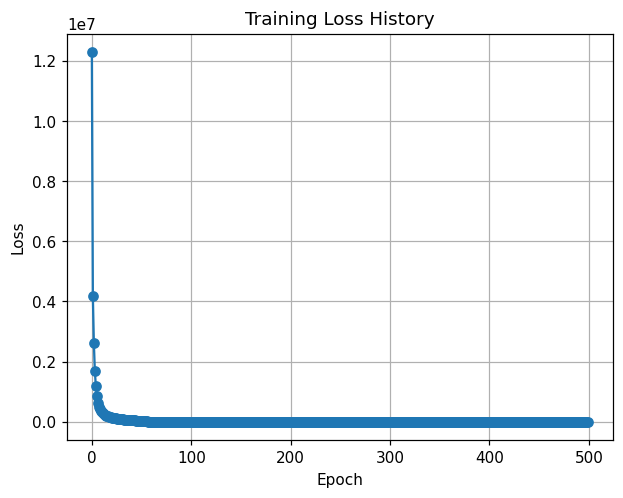

In [10]:
# %%
plt.plot(loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.grid(True)
plt.show()


In [ ]:
# # after training
# save_path = "denoiser.pth"
# torch.save(model.state_dict(), save_path)
# print(f"Model weights saved to {save_path}")


Original ranges:
h_true: min=1299.2476, max=690259.2500
h_input_noisy: min=1295.9894, max=692224.0000
pred: min=-9.3300, max=16.7904


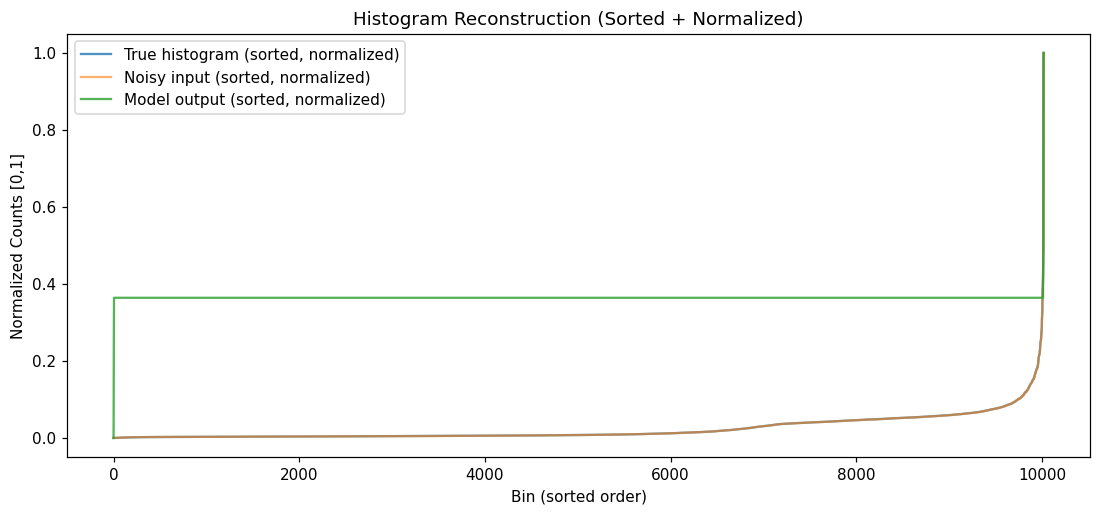

In [ ]:
# %%
# grab one sample from dataloader
h_rec, h_res = dataset[0]
h_rec = h_rec.squeeze().to(device)   # (L,)
h_res = h_res.squeeze().to(device)   # (L,)
print(f"Sample shape: {h_rec.shape}, Residual shape: {h_res.shape}")

# build "ground truth histogram"
h_true = h_rec + h_res  # (L,)

# normalize depending on training mode
# if use_kl:
#     # KL divergence mode: normalize to sum=1
#     h_true_norm = h_true / (h_true.sum() + 1e-8)
#     h_input_norm = h_rec / (h_rec.sum() + 1e-8)
# else:
    # MSE mode: standardize using dataset mean/std
h_true_norm = (h_true - mean_src) / (std_src + 1e-8)
h_input_norm = (h_rec - mean_src) / (std_src + 1e-8)

# add Gaussian noise (as done in training)
h_input_noisy = h_rec + torch.randn_like(h_rec) * noise_std

# forward through model
with torch.no_grad():
    pred = model(h_input_noisy.unsqueeze(0).unsqueeze(0))  # (1,1,L)
pred = pred.squeeze().cpu()

# de-normalize / convert back for plotting
# if use_kl:
    # convert predicted probabilities back to counts proportional to h_true sum
    # pred_denorm = pred / pred.sum() * h_true.cpu().sum()
    # input_denorm = h_input_noisy.cpu() / h_input_noisy.cpu().sum() * h_true.cpu().sum()
    # h_true_plot = h_true.cpu()
# else:
    # pred_denorm = pred * (std_src + 1e-8) + mean_src
    # input_denorm = h_input_noisy.cpu() * (std_src + 1e-8) + mean_src
    # h_true_plot = h_true.cpu() * (std_src + 1e-8) + mean_src

print(f"lengths: h_true - {h_true.shape}, h_input_noisy - {h_input_noisy.shape}, pred - {pred.shape}")

# --- Prepare for plotting ---
h_true_np = h_true.cpu().numpy()
h_input_np = h_input_noisy.cpu().numpy()
pred_np = pred.cpu().numpy()

# print original scales
print("Original scales:")
print(f"  h_true    -> min {h_true_np.min():.4f}, max {h_true_np.max():.4f}, sum {h_true_np.sum():.4f}")
print(f"  noisy_in  -> min {h_input_np.min():.4f}, max {h_input_np.max():.4f}, sum {h_input_np.sum():.4f}")
print(f"  pred      -> min {pred_np.min():.4f}, max {pred_np.max():.4f}, sum {pred_np.sum():.4f}")

# min-max normalize for plotting (each individually to [0,1])
def minmax(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

h_true_normed = minmax(h_true_np)
h_input_normed = minmax(h_input_np)
pred_normed = minmax(pred_np)

# --- Plot histograms ---
plt.figure(figsize=(12,5))
plt.plot(h_true_normed, label="True histogram (scaled)", alpha=0.8)
plt.plot(h_input_normed, label="Noisy input (scaled)", alpha=0.6)
plt.plot(pred_normed, label="Model output (scaled)", alpha=0.8)
plt.legend()
plt.title("Histogram Reconstruction Example (Min-Max Normalized for Plotting)")
plt.xlabel("Bin index")
plt.ylabel("Scaled Counts (0-1)")
plt.show()

# # optionally: bar plot for better visualization of counts per bin
# plt.figure(figsize=(12,5))
# plt.bar(np.arange(len(h_true.cpu().numpy())), h_true.cpu().numpy(), alpha=0.5, label="True histogram")
# plt.bar(np.arange(len(h_true.cpu().numpy())), h_input_noisy.cpu().numpy(), alpha=0.5, label="Noisy input")
# plt.bar(np.arange(len(h_true.cpu().numpy())), pred.cpu().numpy(), alpha=0.5, label="Model output")
# plt.legend()
# plt.title("Histogram Reconstruction (Bar Plot)")
# plt.xlabel("Bin index")
# plt.ylabel("Counts / Density")
# plt.show()



In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_original = []
all_reconstructed = []
all_compressed = []
all_model_pred = []   # <-- store model prediction before correction
all_log_x_true = []
all_y_upper = []
all_y_lower = []

with torch.no_grad():
    for i, (x_compressed, residual) in enumerate(dataloader):
        x_compressed = x_compressed.to(device)   # (L, 1)
        residual = residual.to(device)           # (L, 1)

        # --- Ground truth ---
        x_true = x_compressed + residual
        all_original.append(x_true.cpu())

        # --- Store compressed baseline ---
        all_compressed.append(x_compressed.cpu())

        # --- Normalize inputs (same as training) ---
        x_clean = (x_compressed - mean_src) / (std_src + 1e-8)
        x_input = x_clean.unsqueeze(0).permute(0, 2, 1)  # (1, 1, L)

        # Model prediction (normalized)
        pred = model(x_input)             # shape (1, 1, L)

        # De-normalize to original space
        pred_denorm = pred * (std_src + 1e-8) + mean_src

        # Store properly scaled prediction
        all_model_pred.append(torch.tensor(pred_denorm).cpu())
        residual_pred = pred_denorm.cpu() - x_compressed.squeeze().cpu().numpy()

        # --- Log setup for bounds ---
        log_x_true = np.log10(np.abs(x_true.squeeze().cpu().numpy()) + 1e-12)
        y_mid, y_upper, y_lower, x_step = compute_rule_based_residual_magnitude(
            log_x_true, m=10, epsilon=0.5
        )
        all_log_x_true.append(log_x_true)
        all_y_upper.append(y_upper)
        all_y_lower.append(y_lower)

        # # --- Correction (your existing rule) ---
        # res_np = residual_pred.squeeze().cpu().numpy()
        # log_residual = np.sign(res_np) * np.log10(np.abs(res_np) + 1e-12)
        # corrected_residual = np.zeros_like(res_np)
        # threshold = 0.4

        # for j in range(len(log_residual)):
        #     res = log_residual[j]
        #     if res > 0:
        #         neg_res = -res
        #         margin = neg_res - y_lower[j]
        #         if np.abs(margin) < threshold and (neg_res > y_lower[i]-0.2):
        #             corrected_residual[j] = np.sign(neg_res) * 10**np.abs(neg_res)
        #     elif res < 0:
        #         pos_res = -res
        #         margin = y_upper[j] - pos_res
        #         if np.abs(margin) < threshold and (pos_res < y_upper[i]+0.2):
        #             corrected_residual[j] = np.sign(pos_res) * 10**np.abs(pos_res)

        x_reconstructed = x_compressed.squeeze().cpu().numpy() + residual_pred
        all_reconstructed.append(torch.tensor(x_reconstructed))

        if i > 4:
            break

# --- Stack all ---
all_original = torch.cat(all_original).numpy().flatten()
all_compressed = torch.cat(all_compressed).numpy().flatten()
all_reconstructed = torch.cat(all_reconstructed).numpy().flatten()
all_model_pred = torch.cat(all_model_pred).numpy().flatten()
all_log_x_true = np.concatenate(all_log_x_true)
all_y_upper = np.concatenate(all_y_upper)
all_y_lower = np.concatenate(all_y_lower)

# --- Compute residuals ---
residual_corrected = all_reconstructed - all_original
residual_model = all_compressed - all_original

log_residual_corrected = np.sign(residual_corrected) * np.log10(np.abs(residual_corrected) + 1e-12)
log_residual_model = np.sign(residual_model) * np.log10(np.abs(residual_model) + 1e-12)

print(all_model_pred)
plt.figure(figsize=(12,4))
plt.hist(all_model_pred, bins=1000, alpha=0.6, label="Prediction", density=True)
plt.legend()
plt.title("Denoising Example (Histograms)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(0, 75000)
plt.show()

# --- Scatter plot ---
plt.figure(figsize=(10, 6))
plt.scatter(all_compressed, log_residual_corrected, s=10, alpha=0.6, c='blue', label='Corrected Residuals')
plt.scatter(all_compressed, log_residual_model, s=10, alpha=0.6, c='orange', label='Model Residuals')
plt.scatter(10**all_log_x_true, all_y_upper, c='r', s=5, label='y_upper')
plt.scatter(10**all_log_x_true, all_y_lower, c='r', s=5, label='y_lower')

plt.xlabel("Compressed Value")
plt.ylabel("Signed log10 Residual (Reconstructed - Original)")
plt.title("Scatter: Corrected vs Model Residuals")
plt.grid(True)
plt.xscale('log')
plt.legend()
plt.show()

print("MSE compressed → original:", np.average((all_original - all_compressed)**2))
print("MSE corrected  → original:", np.average((all_original - all_reconstructed)**2))


RuntimeError: Given groups=1, weight of size [16, 1, 3], expected input[1, 1000, 4] to have 1 channels, but got 1000 channels instead

In [ ]:

nonzero_idx = np.nonzero(corrected_residual)[0]

# # Print the values
# for idx in nonzero_idx:
#     print(f"Index {idx}: corrected_residual={corrected_residual[idx]:.6f}, "
#           f"compressed={comp[idx]}, corrected={comp[idx]+corrected_residual[idx]:.6f}, original={orig[idx]:.6f}")

correct_count = 0
wrong_count = 0

for idx in nonzero_idx:
    before = abs(all_compressed[idx] - all_original[idx])
    after = abs((all_compressed[idx] + corrected_residual[idx]) - all_original[idx])

    if after < before:
        correct_count += 1
    else:
        wrong_count += 1

print(f"Corrections that improved: {correct_count}")
print(f"Corrections that worsened: {wrong_count}")
print(f"Total corrections: {len(nonzero_idx)}")
print(f"Accuracy: {correct_count / len(nonzero_idx):.2%}")


Corrections that improved: 56
Corrections that worsened: 279
Total corrections: 335
Accuracy: 16.72%


numpy.ndarray

In [ ]:
print("Residual range:", min(results["res"]), max(results["res"]))
print("y_lower range:", float(y_lower.min()), float(y_lower.max()))
print("y_upper range:", float(y_upper.min()), float(y_upper.max()))


Residual range: -5.2019825 6.078592
y_lower range: -2.9082399653118496 -0.5
y_upper range: 0.5 2.9082399653118496


In [ ]:
np.count_nonzero(results["res"]), len(results["res"])
# results["res"]

(1000, 1000)

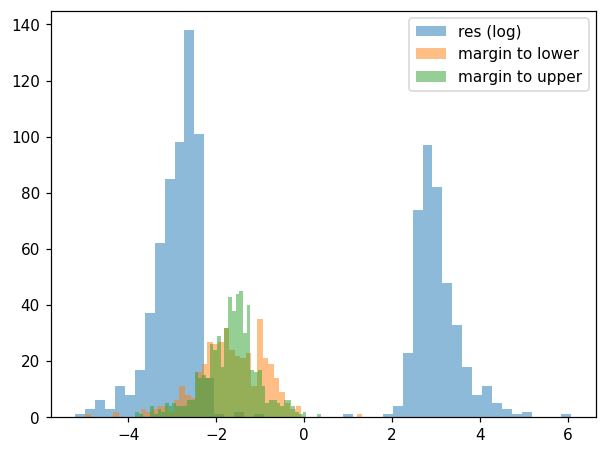

In [ ]:
import matplotlib.pyplot as plt

plt.hist(results["res"], bins=50, alpha=0.5, label="res (log)")
plt.hist(results["margin_to_lower"], bins=50, alpha=0.5, label="margin to lower")
plt.hist(results["margin_to_upper"], bins=50, alpha=0.5, label="margin to upper")
plt.legend()
plt.show()


In [ ]:
print("Total residuals:", len(results["res"]))
print("Residuals > 0 (neg_res path):", len(results["neg_res"]))
print("Residuals < 0 (pos_res path):", len(results["pos_res"]))
print("Condition (neg_res > y_lower):", sum(results["cond_lower"]))
print("Condition (pos_res < y_upper):", sum(results["cond_upper"]))


Total residuals: 1000
Residuals > 0 (neg_res path): 412
Residuals < 0 (pos_res path): 588
Condition (neg_res > y_lower): 1
Condition (pos_res < y_upper): 2


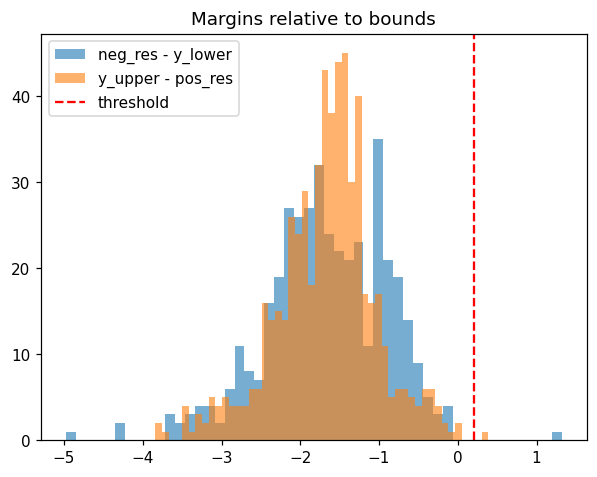

In [ ]:
import matplotlib.pyplot as plt

plt.hist(results["margin_to_lower"], bins=50, alpha=0.6, label="neg_res - y_lower")
plt.hist(results["margin_to_upper"], bins=50, alpha=0.6, label="y_upper - pos_res")
plt.axvline(threshold, color="red", linestyle="--", label="threshold")
plt.legend()
plt.title("Margins relative to bounds")
plt.show()


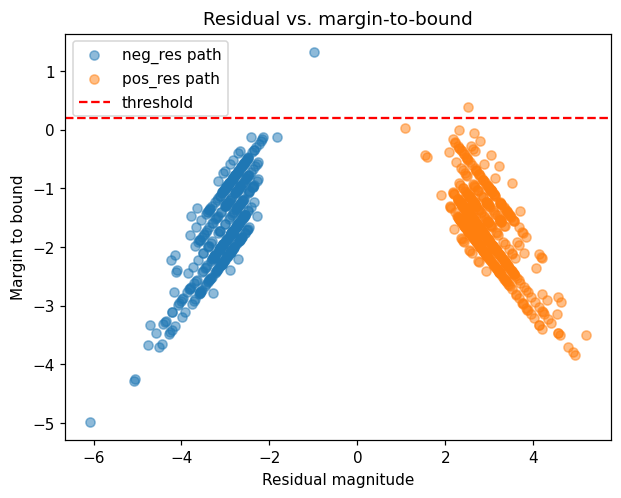

In [ ]:
plt.scatter(results["neg_res"], results["margin_to_lower"], alpha=0.5, label="neg_res path")
plt.scatter(results["pos_res"], results["margin_to_upper"], alpha=0.5, label="pos_res path")
plt.axhline(threshold, color="red", linestyle="--", label="threshold")
plt.xlabel("Residual magnitude")
plt.ylabel("Margin to bound")
plt.legend()
plt.title("Residual vs. margin-to-bound")
plt.show()


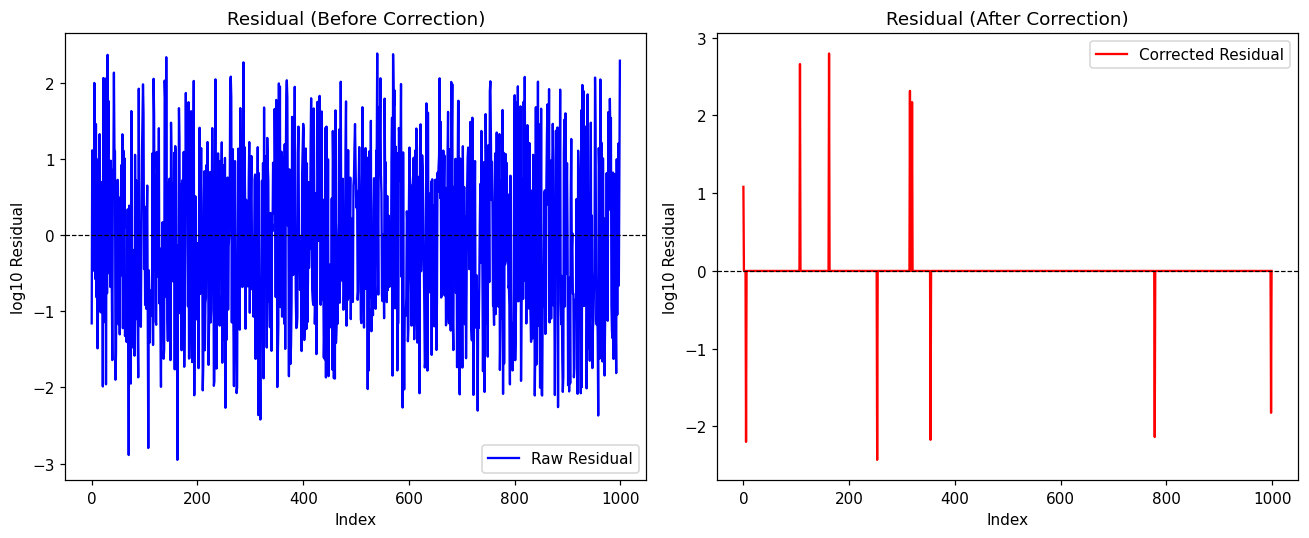

In [ ]:
import matplotlib.pyplot as plt

# Assume log_residual (before correction) and corrected_residual (after correction) 
# are numpy arrays of the same length

plt.figure(figsize=(12, 5))

# --- Before correction ---
plt.subplot(1, 2, 1)
plt.plot(log_residual, label="Raw Residual", color="blue")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Residual (Before Correction)")
plt.xlabel("Index")
plt.ylabel("log10 Residual")
plt.legend()

# --- After correction ---
plt.subplot(1, 2, 2)
plt.plot(corrected_residual, label="Corrected Residual", color="red")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Residual (After Correction)")
plt.xlabel("Index")
plt.ylabel("log10 Residual")
plt.legend()

plt.tight_layout()
plt.show()


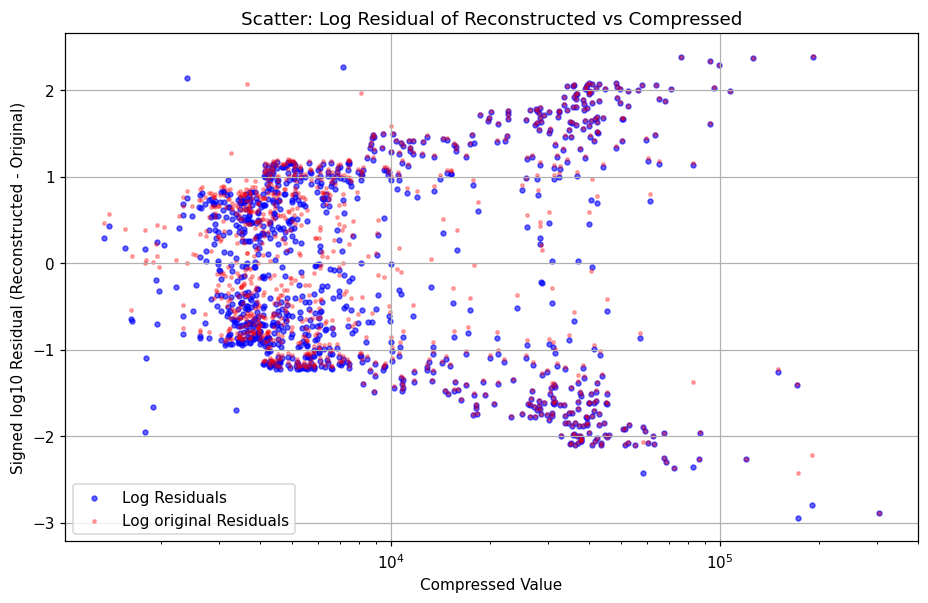

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch


# Compute residual (reconstructed - original)
residual = recon - orig
residual_og = comp - orig

# Compute signed log10 residual
log_residual = np.sign(residual) * np.log10(np.abs(residual) + 1e-12)
log_resigual_og = np.sign(residual_og) * np.log10(np.abs(residual_og) + 1e-12)
# Scatter plot: compressed vs log residual
plt.figure(figsize=(10, 6))
plt.scatter(comp, log_residual, s=10, alpha=0.6, c='blue', label='Log Residuals')
plt.scatter(comp, log_resigual_og, s=5, alpha=0.3, c='red', label='Log original Residuals')
plt.xlabel("Compressed Value")
plt.ylabel("Signed log10 Residual (Reconstructed - Original)")
plt.title("Scatter: Log Residual of Reconstructed vs Compressed")
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()
